# Data exploration

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import missingno as msno
from typing import List, Optional

class DatasetExplorer:
    """
    A comprehensive tool for initial dataset exploration and visualization.
    This class implements best practices for understanding data characteristics
    and identifying potential issues early in the analysis process.
    """
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.numeric_columns = df.select_dtypes(include=[np.number]).columns
        self.categorical_columns = df.select_dtypes(exclude=[np.number]).columns
        
    def plot_data_completeness(self):
        """
        Visualizes missing values and data completeness patterns.
        This helps identify potential data quality issues early.
        """
        plt.figure(figsize=(12, 6))
        
        # Create missing values heatmap
        plt.subplot(1, 2, 1)
        msno.matrix(self.df)
        plt.title('Missing Values Pattern')
        
        # Create missing values correlation
        plt.subplot(1, 2, 2)
        msno.heatmap(self.df)
        plt.title('Missing Values Correlation')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        missing_stats = self.df.isnull().sum().sort_values(ascending=False)
        print("\nMissing Values Summary:")
        print(missing_stats[missing_stats > 0])
        
    def plot_class_balance(self, target_column: str):
        """
        Visualizes the distribution of classes in the target variable.
        Essential for understanding potential class imbalance issues.
        """
        plt.figure(figsize=(10, 6))
        
        # Create class distribution plot
        class_counts = self.df[target_column].value_counts()
        sns.barplot(x=class_counts.index, y=class_counts.values)
        
        # Add percentage labels
        total = len(self.df)
        for i, v in enumerate(class_counts.values):
            plt.text(i, v, f'{(v/total)*100:.1f}%', ha='center', va='bottom')
            
        plt.title('Class Distribution in Target Variable')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.show()
        
        # Print class balance metrics
        print("\nClass Balance Metrics:")
        for cls in class_counts.index:
            print(f"Class {cls}: {class_counts[cls]} samples ({(class_counts[cls]/total)*100:.1f}%)")

    def _plot_categorical_distributions(self, n_cols: int):
        """
        Creates visualization for categorical features showing their value distributions.
        
        This method complements the numeric distributions by:
        - Showing frequency of each category
        - Calculating percentage distributions
        - Identifying rare categories that might need special handling
        
        Args:
            n_cols: Number of columns in the subplot grid
        """
        n_categorical = len(self.categorical_columns)
        if n_categorical == 0:
            return
            
        # Calculate number of rows needed based on number of categorical columns
        n_rows = (n_categorical + n_cols - 1) // n_cols
        
        # Create a figure with subplots
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        
        # Handle single row case where axes isn't 2D
        axes = axes.flatten() if n_rows > 1 else [axes] if n_cols > 1 else [[axes]]
        
        for idx, col in enumerate(self.categorical_columns):
            # Calculate value counts and percentages
            value_counts = self.df[col].value_counts()
            percentages = (value_counts / len(self.df) * 100).round(1)
            
            # Create bar plot
            ax = axes[idx] if n_rows > 1 or n_cols > 1 else axes[0]
            sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax)
            
            # Rotate x-labels if there are many categories
            if len(value_counts) > 5:
                ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            
            # Add percentage labels on top of each bar
            for i, (count, percentage) in enumerate(zip(value_counts, percentages)):
                ax.text(i, count, f'{percentage}%', 
                    ha='center', va='bottom')
            
            # Set title and labels
            ax.set_title(f'{col} Distribution')
            ax.set_ylabel('Count')
            
            # Add total count in corner
            ax.text(0.95, 0.95, f'n={len(self.df)}', 
                    transform=ax.transAxes, 
                    ha='right', va='top',
                    bbox=dict(facecolor='white', alpha=0.8))
        
        # Remove any empty subplots
        for idx in range(len(self.categorical_columns), len(axes)):
            if n_rows > 1 or n_cols > 1:
                fig.delaxes(axes[idx])
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics for categorical variables
        print("\nCategorical Features Summary:")
        for col in self.categorical_columns:
            print(f"\n{col}:")
            value_counts = self.df[col].value_counts()
            percentages = (value_counts / len(self.df) * 100).round(1)
            summary_df = pd.DataFrame({
                'Count': value_counts,
                'Percentage': percentages
            })
            print(summary_df)
            
    def plot_feature_distributions(self, n_cols: int = 3):
        """
        Creates distribution plots for all features, separated by type.
        Helps identify potential outliers and understand data shapes.
        """
        # Plot numeric features
        self._plot_numeric_distributions(n_cols)
        
        # Plot categorical features
        self._plot_categorical_distributions(n_cols)
        
    def _plot_numeric_distributions(self, n_cols: int):
        """Helper method for plotting numeric feature distributions"""
        n_numeric = len(self.numeric_columns)
        if n_numeric == 0:
            return
            
        n_rows = (n_numeric + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        axes = axes.flatten() if n_rows > 1 else [axes]
        
        for ax, col in zip(axes, self.numeric_columns):
            # Create distribution plot
            sns.histplot(data=self.df, x=col, kde=True, ax=ax)
            ax.set_title(f'{col} Distribution')
            
            # Add summary statistics
            mean_val = self.df[col].mean()
            median_val = self.df[col].median()
            ax.axvline(mean_val, color='r', linestyle='--', alpha=0.5)
            ax.axvline(median_val, color='g', linestyle='--', alpha=0.5)
            
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\nNumeric Features Summary:")
        print(self.df[self.numeric_columns].describe())
        
    def plot_correlation_matrix(self):
        """
        Visualizes correlations between numeric features.
        Helps identify potential multicollinearity and feature relationships.
        """
        plt.figure(figsize=(12, 8))
        
        # Create correlation matrix
        corr_matrix = self.df[self.numeric_columns].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        plt.show()
        
    def plot_feature_importance(self, target_column: str):
        """
        Creates visualizations showing the relationship between features
        and the target variable, with robust handling of missing and invalid values.
        
        Args:
            target_column: The name of the target variable column
        """
        plt.figure(figsize=(12, 6))
        
        # Initialize lists to store our correlation results
        correlations = []
        
        for col in self.numeric_columns:
            if col != target_column:
                # Get the data for this feature
                feature_data = self.df[col]
                target_data = self.df[target_column]
                
                # Clean the data by removing inf, -inf, and nan values
                valid_indices = ~(np.isinf(feature_data) | 
                                np.isnan(feature_data) | 
                                np.isinf(target_data) | 
                                np.isnan(target_data))
                
                clean_feature = feature_data[valid_indices]
                clean_target = target_data[valid_indices]
                
                # Only calculate correlation if we have enough valid data points
                if len(clean_feature) > 1:
                    try:
                        # Calculate point-biserial correlation
                        correlation = stats.pointbiserialr(clean_target, 
                                                        clean_feature)[0]
                        
                        # Store the result if it's valid
                        if not np.isnan(correlation):
                            correlations.append((col, abs(correlation)))
                            
                    except Exception as e:
                        print(f"Warning: Could not calculate correlation for {col}: {str(e)}")
                        
        # Sort correlations by absolute value
        correlations.sort(key=lambda x: x[1], reverse=True)
        
        # Create the visualization only if we have valid correlations
        if correlations:
            features, scores = zip(*correlations)
            
            # Create the bar plot
            sns.barplot(x=list(scores), y=list(features))
            
            plt.title('Feature Importance (Correlation with Target)')
            plt.xlabel('Absolute Correlation')
            
            # Add correlation values as text
            for i, score in enumerate(scores):
                plt.text(score, i, f'{score:.3f}', 
                        va='center', ha='left', 
                        transform=plt.gca().transData)
                
            # Add data quality note
            plt.figtext(0.99, 0.01, 
                    'Note: Correlations calculated after removing invalid values',
                    ha='right', va='bottom', 
                    fontsize=8, style='italic')
        else:
            plt.text(0.5, 0.5, 
                    'No valid correlations could be calculated',
                    ha='center', va='center',
                    transform=plt.gca().transData)
        
        plt.tight_layout()
        plt.show()
 
        if correlations:
            print("\nFeature Importance Summary:")
            print("-" * 50)
            for feature, correlation in correlations:
                missing_count = self.df[feature].isna().sum()
                inf_count = np.isinf(self.df[feature]).sum()
                total_invalid = missing_count + inf_count
                
                print(f"\n{feature}:")
                print(f"  Correlation with target: {correlation:.3f}")
                print(f"  Data quality:")
                print(f"    - Valid values: {len(self.df) - total_invalid:,} "
                    f"({(len(self.df) - total_invalid) / len(self.df) * 100:.1f}%)")
                if total_invalid > 0:
                    print(f"    - Missing values: {missing_count:,}")
                    print(f"    - Infinite values: {inf_count:,}")

Step 1: Loading the dataset...

Step 2: Basic Dataset Information
--------------------------------------------------
Dataset Shape: (32581, 12)

Datatype Information:
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

Step 3: Analyzing Data Completeness
--------------------------------------------------


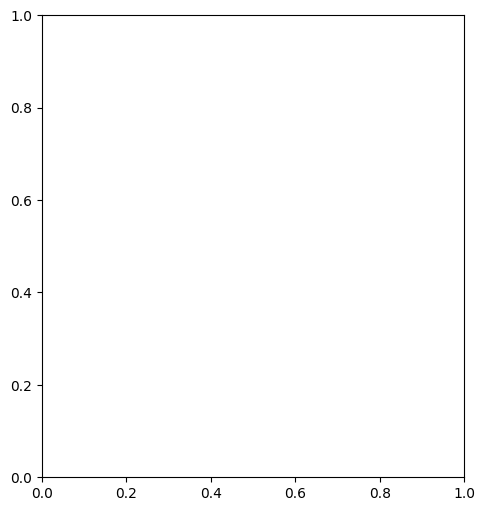

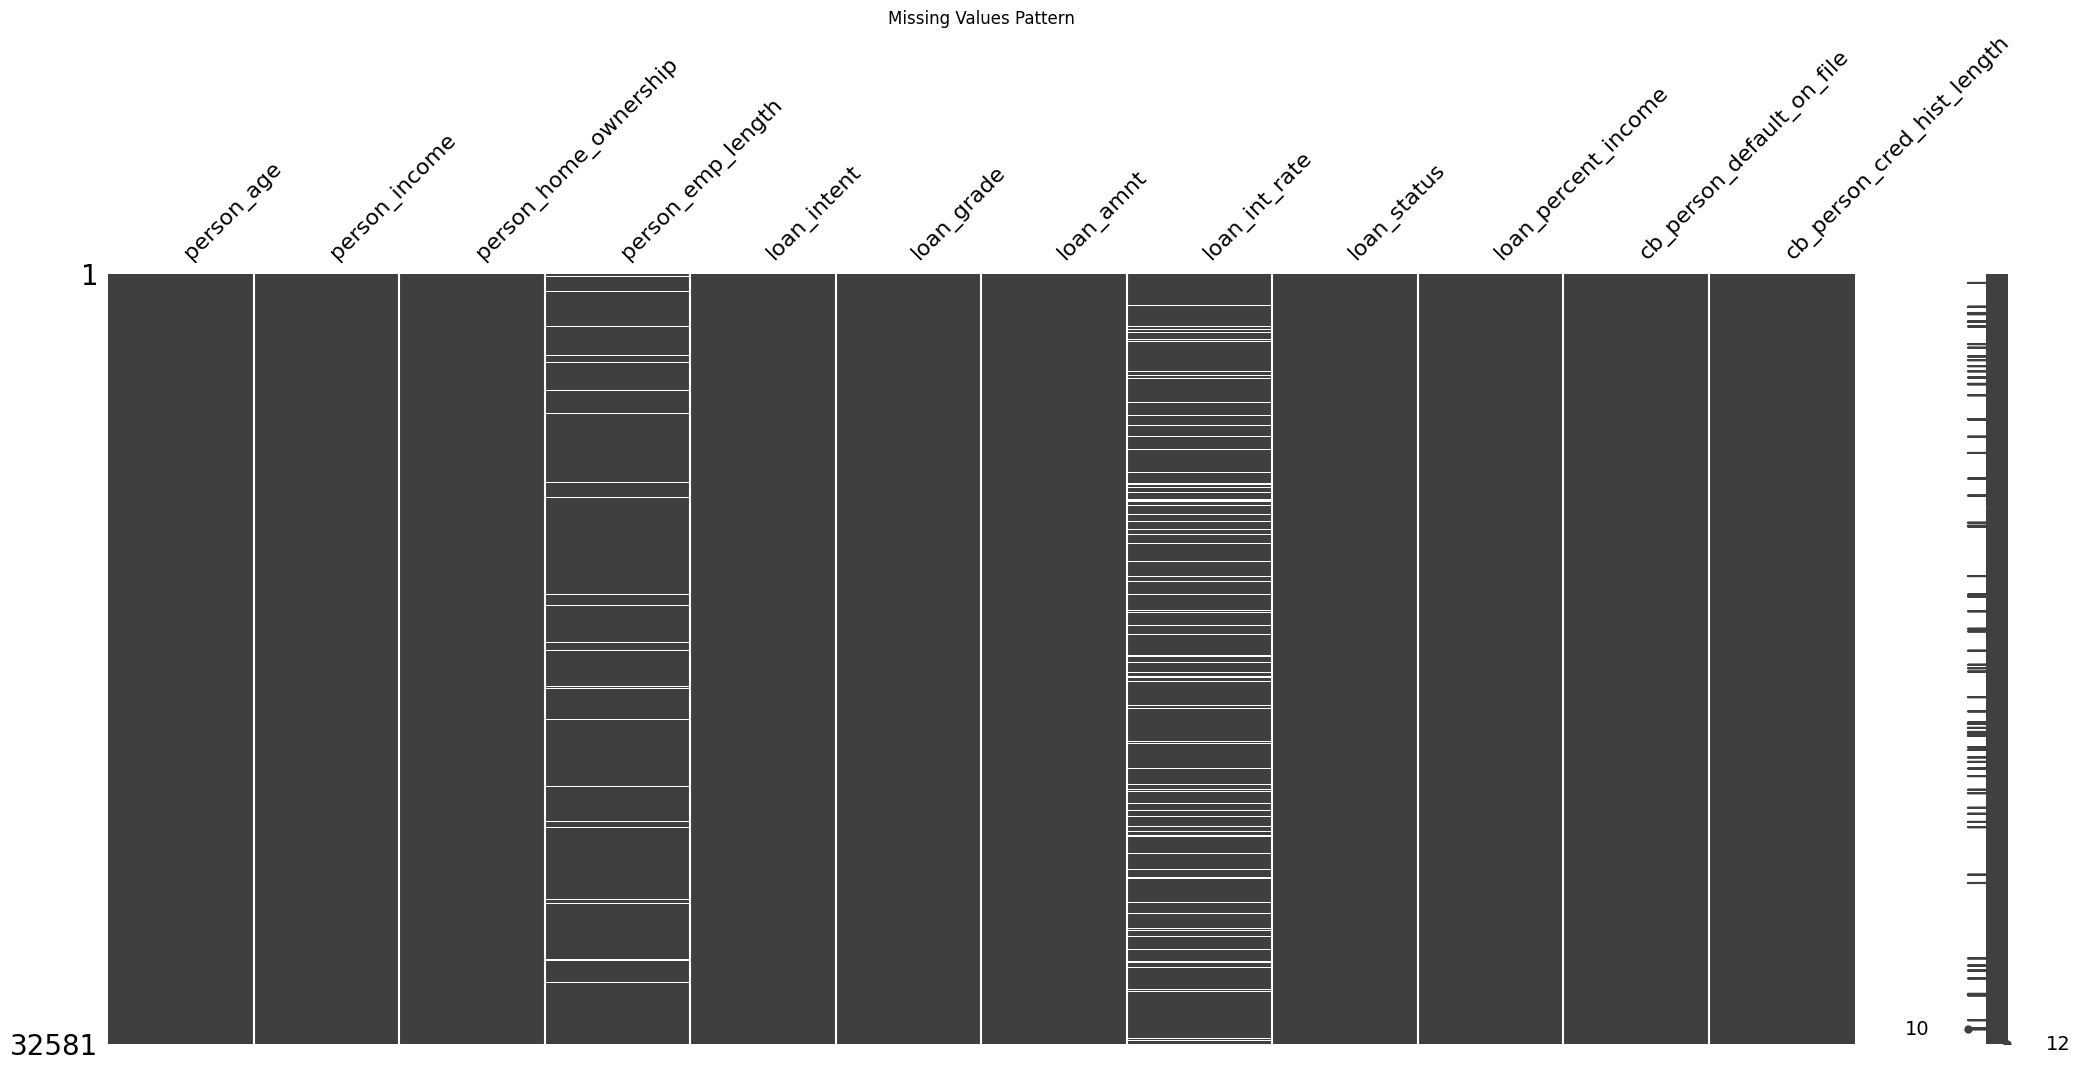

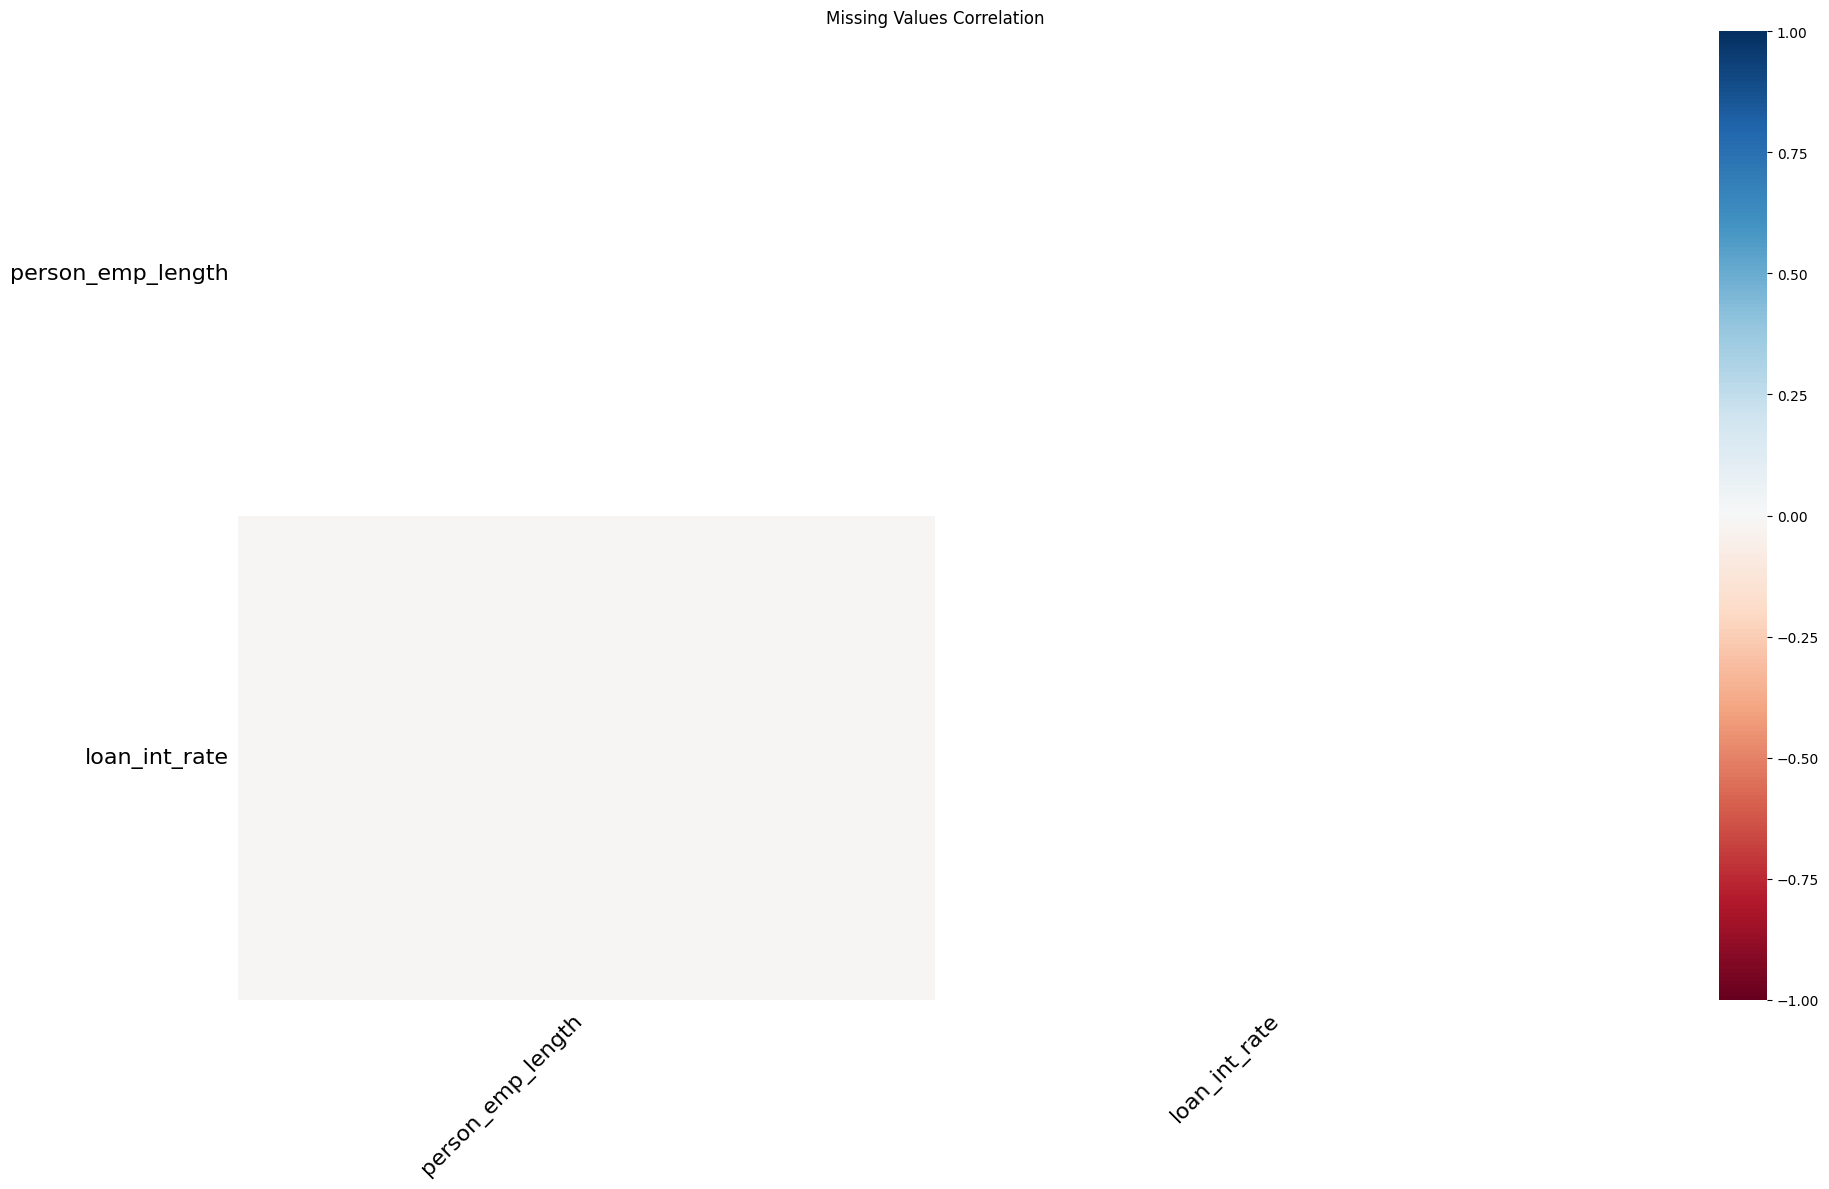

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



Missing Values Summary:
loan_int_rate        3116
person_emp_length     895
dtype: int64

Step 4: Examining Class Balance
--------------------------------------------------


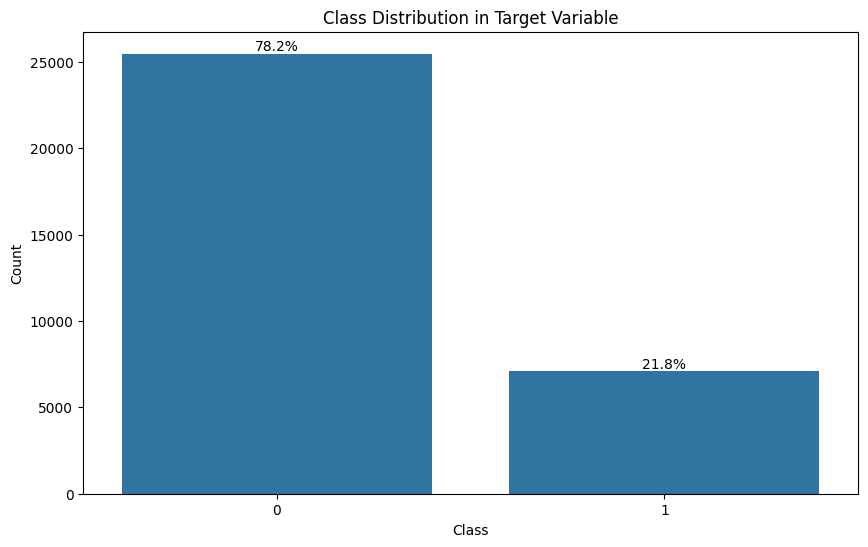


Class Balance Metrics:
Class 0: 25473 samples (78.2%)
Class 1: 7108 samples (21.8%)

Step 5: Analyzing Feature Distributions
--------------------------------------------------


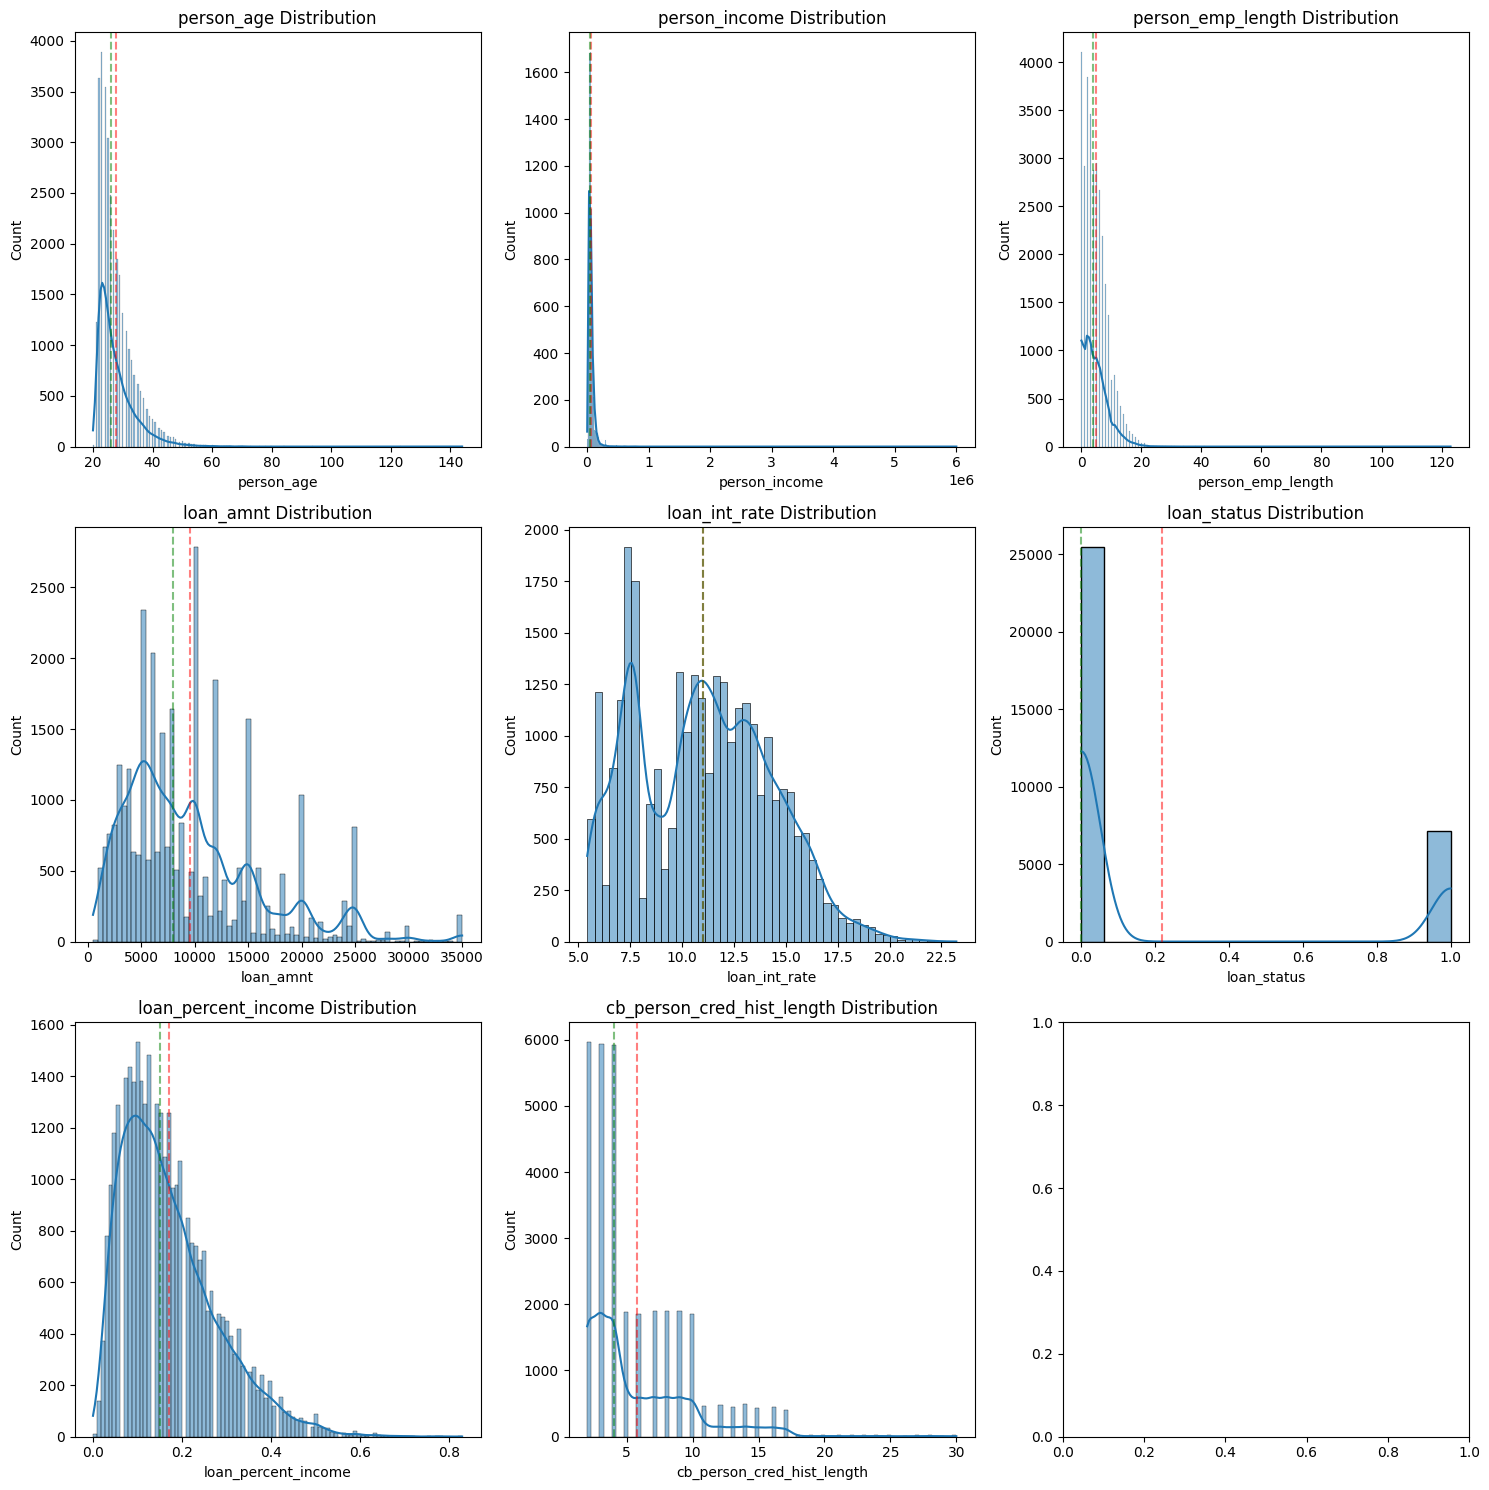


Numeric Features Summary:
         person_age  person_income  person_emp_length     loan_amnt  \
count  32581.000000   3.258100e+04       31686.000000  32581.000000   
mean      27.734600   6.607485e+04           4.789686   9589.371106   
std        6.348078   6.198312e+04           4.142630   6322.086646   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.850000e+04           2.000000   5000.000000   
50%       26.000000   5.500000e+04           4.000000   8000.000000   
75%       30.000000   7.920000e+04           7.000000  12200.000000   
max      144.000000   6.000000e+06         123.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   29465.000000  32581.000000         32581.000000   
mean       11.011695      0.218164             0.170203   
std         3.240459      0.413006             0.106782   
min         5.420000      0.000000             0.000000   
25%         7.900000      0.000000    

/var/folders/dp/0s_jjpzn3hn44cft710n9x0h0000gn/T/ipykernel_22588/19379959.py:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/dp/0s_jjpzn3hn44cft710n9x0h0000gn/T/ipykernel_22588/19379959.py:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


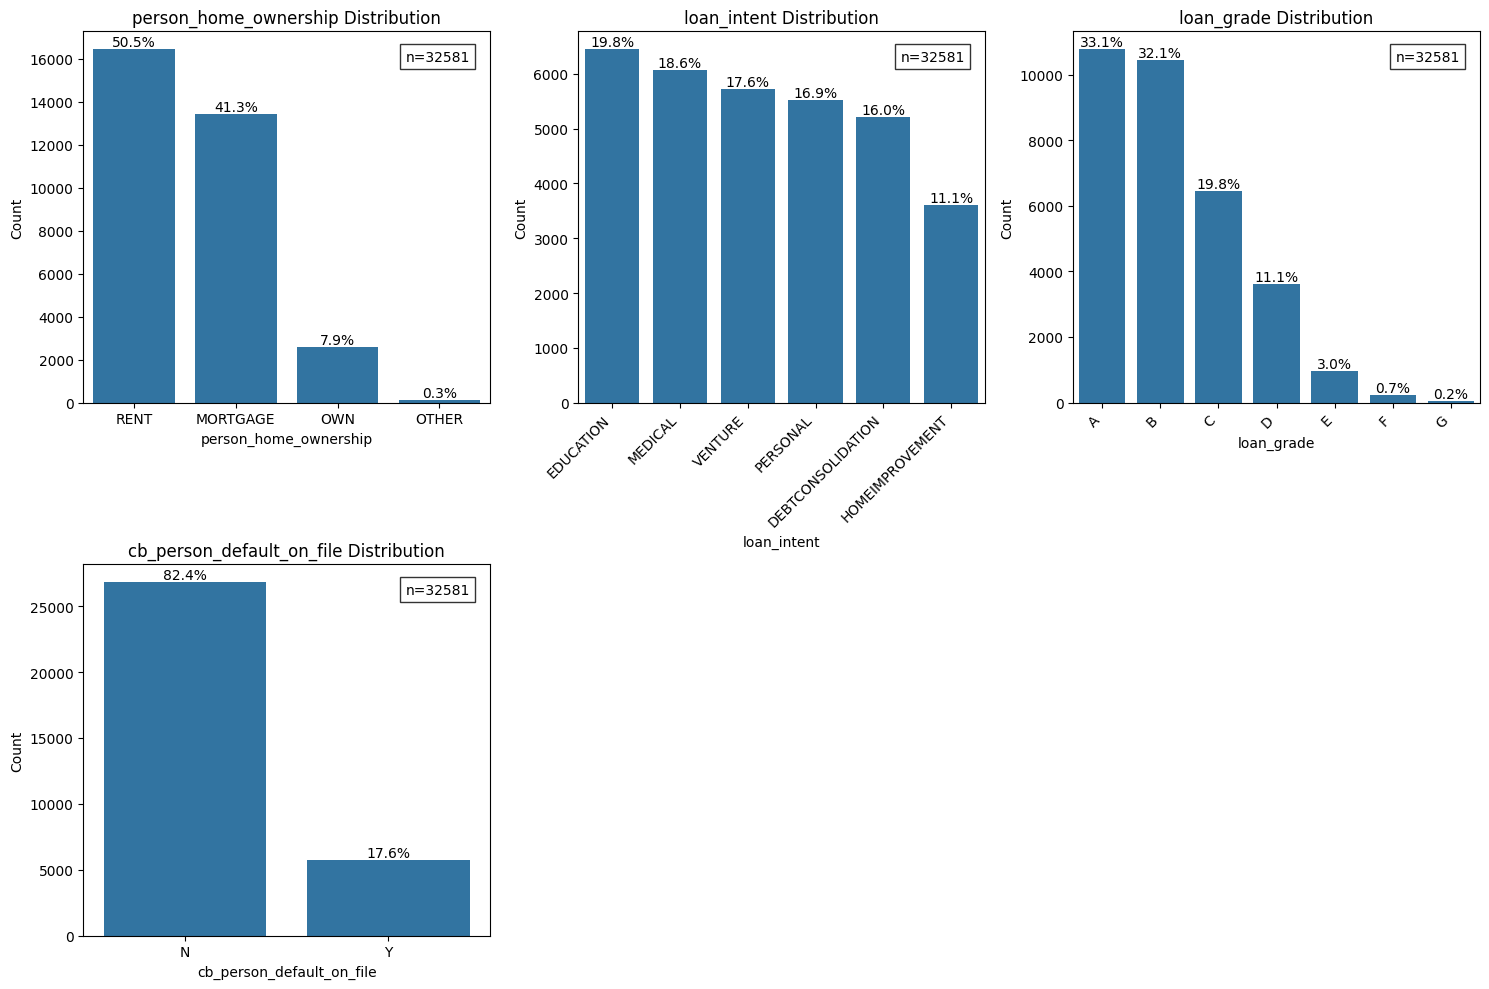


Categorical Features Summary:

person_home_ownership:
                       Count  Percentage
person_home_ownership                   
RENT                   16446        50.5
MORTGAGE               13444        41.3
OWN                     2584         7.9
OTHER                    107         0.3

loan_intent:
                   Count  Percentage
loan_intent                         
EDUCATION           6453        19.8
MEDICAL             6071        18.6
VENTURE             5719        17.6
PERSONAL            5521        16.9
DEBTCONSOLIDATION   5212        16.0
HOMEIMPROVEMENT     3605        11.1

loan_grade:
            Count  Percentage
loan_grade                   
A           10777        33.1
B           10451        32.1
C            6458        19.8
D            3626        11.1
E             964         3.0
F             241         0.7
G              64         0.2

cb_person_default_on_file:
                           Count  Percentage
cb_person_default_on_file        

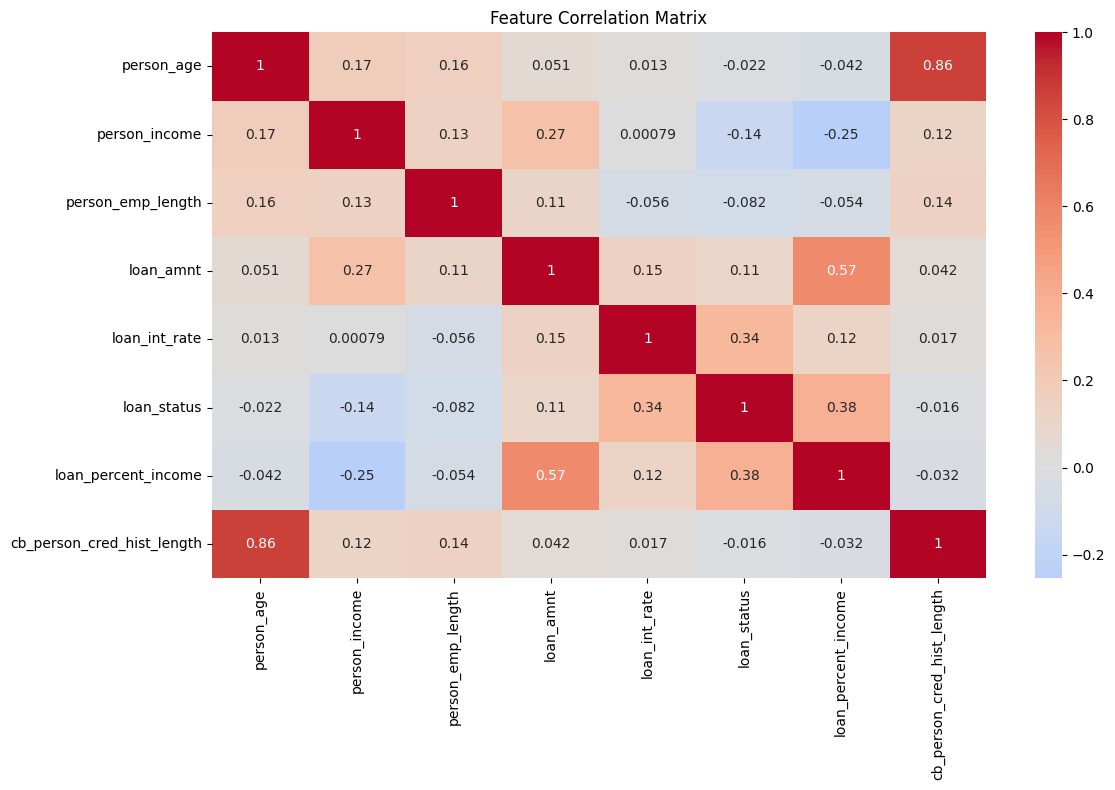


Step 7: Analyzing Feature Importance
--------------------------------------------------


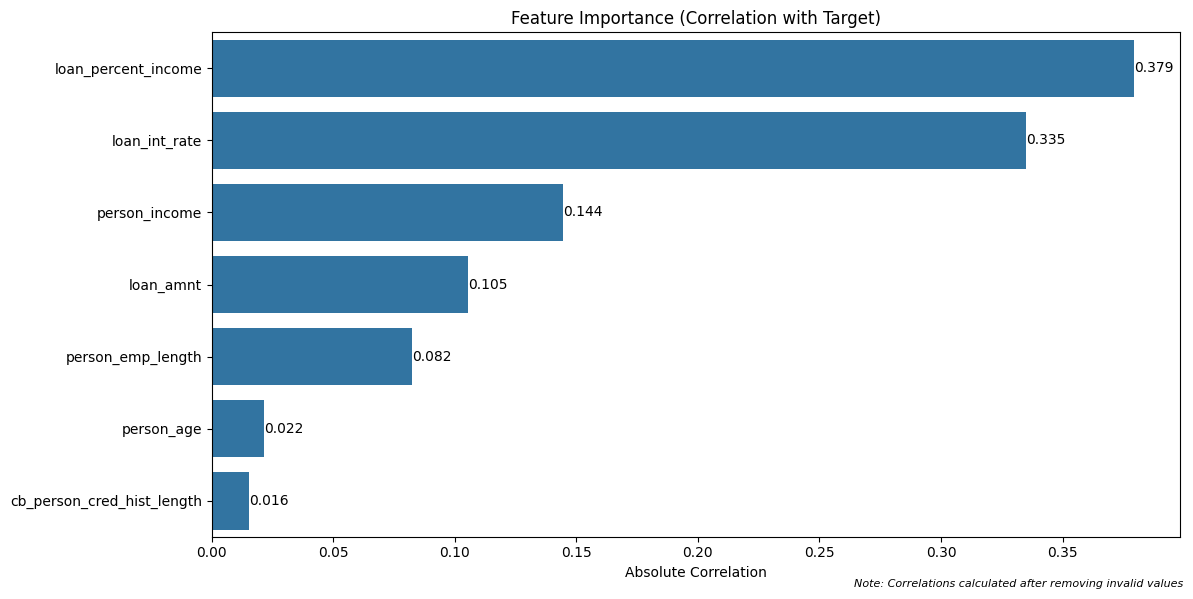


Feature Importance Summary:
--------------------------------------------------

loan_percent_income:
  Correlation with target: 0.379
  Data quality:
    - Valid values: 32,581 (100.0%)

loan_int_rate:
  Correlation with target: 0.335
  Data quality:
    - Valid values: 29,465 (90.4%)
    - Missing values: 3,116
    - Infinite values: 0

person_income:
  Correlation with target: 0.144
  Data quality:
    - Valid values: 32,581 (100.0%)

loan_amnt:
  Correlation with target: 0.105
  Data quality:
    - Valid values: 32,581 (100.0%)

person_emp_length:
  Correlation with target: 0.082
  Data quality:
    - Valid values: 31,686 (97.3%)
    - Missing values: 895
    - Infinite values: 0

person_age:
  Correlation with target: 0.022
  Data quality:
    - Valid values: 32,581 (100.0%)

cb_person_cred_hist_length:
  Correlation with target: 0.016
  Data quality:
    - Valid values: 32,581 (100.0%)


In [15]:
def analyze_credit_risk_dataset(data_path: str):
    """
    Demonstrates a comprehensive workflow for initial dataset exploration.
    Follows data science best practices for understanding new datasets.
    """
    # Step 1: Load the data
    print("Step 1: Loading the dataset...")
    df = pd.read_csv(data_path)
    explorer = DatasetExplorer(df)
    
    # Step 2: Understand basic dataset characteristics
    print("\nStep 2: Basic Dataset Information")
    print("-" * 50)
    print(f"Dataset Shape: {df.shape}")
    print("\nDatatype Information:")
    print(df.dtypes)
    
    # Step 3: Analyze data completeness
    print("\nStep 3: Analyzing Data Completeness")
    print("-" * 50)
    explorer.plot_data_completeness()
    
    # Step 4: Examine class balance
    print("\nStep 4: Examining Class Balance")
    print("-" * 50)
    explorer.plot_class_balance('loan_status')
    
    # Step 5: Analyze feature distributions
    print("\nStep 5: Analyzing Feature Distributions")
    print("-" * 50)
    explorer.plot_feature_distributions()
    
    # Step 6: Examine feature correlations
    print("\nStep 6: Examining Feature Correlations")
    print("-" * 50)
    explorer.plot_correlation_matrix()
    
    # Step 7: Analyze feature importance
    print("\nStep 7: Analyzing Feature Importance")
    print("-" * 50)
    explorer.plot_feature_importance('loan_status')
    
    return explorer

# Usage
explorer = analyze_credit_risk_dataset("credit_risk_dataset.csv")

In [17]:
len(df)

32581

# Training with handling class imbalance

In [11]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple, Union
import logging
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class ClassWeightHandler:
    """Handles class weight calculation and application for imbalanced datasets"""
    def __init__(self, weight_type: str = 'balanced'):
        self.weight_type = weight_type
        self.class_weights = None
        
    def calculate_weights(self, y: np.ndarray) -> Dict[int, float]:
        try:
            classes = np.unique(y)
            class_counts = np.bincount(y.astype(int))
            
            if self.weight_type == 'balanced':
                weights = compute_class_weight(
                    class_weight='balanced',
                    classes=classes,
                    y=y
                )
                self.class_weights = dict(zip(classes, weights))
                
            elif self.weight_type == 'custom':
                n_samples = len(y)
                weights = n_samples / (len(classes) * class_counts)
                self.class_weights = dict(zip(classes, weights))
            
            logger.info(f"Calculated class weights: {self.class_weights}")
            return self.class_weights
            
        except Exception as e:
            logger.error(f"Error calculating class weights: {str(e)}")
            raise
            
    def get_sample_weights(self, y: np.ndarray) -> np.ndarray:
        if self.class_weights is None:
            self.calculate_weights(y)
        return np.array([self.class_weights[label] for label in y])
    
    def get_weight_dict(self) -> Dict[int, float]:
        if self.class_weights is None:
            raise ValueError("Weights have not been calculated yet. Call calculate_weights first.")
        return self.class_weights
    
    def adjust_predictions(self, y_pred_proba: np.ndarray, threshold: float = 0.5) -> np.ndarray:
        if len(y_pred_proba.shape) == 2:
            adjusted_threshold = threshold * (self.class_weights[0] / self.class_weights[1])
            return (y_pred_proba[:, 1] > adjusted_threshold).astype(int)
        else:
            adjusted_threshold = threshold * (self.class_weights[0] / self.class_weights[1])
            return (y_pred_proba > adjusted_threshold).astype(int)

class DataSplitter:
    """Handles train/validation/test splitting with stratification"""
    def __init__(
        self,
        test_size: float = 0.2,
        val_size: float = 0.2,
        random_state: int = 42
    ):
        self.test_size = test_size
        self.val_size = val_size
        self.random_state = random_state
        
    def split_data(
        self,
        X: np.ndarray,
        y: np.ndarray,
        sample_weights: np.ndarray = None
    ) -> Dict[str, np.ndarray]:
        try:
            # First split: separate test set
            X_temp, X_test, y_temp, y_test = train_test_split(
                X,
                y,
                test_size=self.test_size,
                stratify=y,
                random_state=self.random_state
            )
            
            # Second split: separate validation set
            val_size_adjusted = self.val_size / (1 - self.test_size)
            X_train, X_val, y_train, y_val = train_test_split(
                X_temp,
                y_temp,
                test_size=val_size_adjusted,
                stratify=y_temp,
                random_state=self.random_state
            )
            
            # Handle sample weights if provided
            if sample_weights is not None:
                weights_temp, weights_test = train_test_split(
                    sample_weights,
                    test_size=self.test_size,
                    random_state=self.random_state
                )
                weights_train, weights_val = train_test_split(
                    weights_temp,
                    test_size=val_size_adjusted,
                    random_state=self.random_state
                )
            else:
                weights_train = weights_val = weights_test = None
            
            # Log split information
            logger.info(f"Training set size: {X_train.shape[0]}")
            logger.info(f"Validation set size: {X_val.shape[0]}")
            logger.info(f"Test set size: {X_test.shape[0]}")
            
            return {
                'X_train': X_train,
                'X_val': X_val,
                'X_test': X_test,
                'y_train': y_train,
                'y_val': y_val,
                'y_test': y_test,
                'train_weights': weights_train,
                'val_weights': weights_val,
                'test_weights': weights_test
            }
            
        except Exception as e:
            logger.error(f"Error in data splitting: {str(e)}")
            raise

class DataPreprocessor:
    """Handles data preprocessing for credit risk analysis"""
    def __init__(self, max_features: int = None, n_neighbors: int = 5):
        self.max_features = max_features
        self.n_neighbors = n_neighbors
        self.label_encoders = {}
        self.scaler = StandardScaler()
        self.imputer = KNNImputer(n_neighbors=n_neighbors)
        self.pca = None
        
        # Define important features based on correlation analysis
        self.numerical_columns = [
            'loan_percent_income',  # 0.379 correlation
            'loan_int_rate',        # 0.335 correlation
            'person_income',        # 0.144 correlation
            'loan_amnt',           # 0.105 correlation
            'person_emp_length',    # 0.082 correlation
            'person_age'           # 0.022 correlation
        ]
        
        self.categorical_columns = [
            'person_home_ownership',
            'loan_intent',
            'loan_grade'
        ]
    
    def _engineer_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Engineer additional features"""
        df = df.copy()
        
        # Monthly payment calculation
        df['monthly_payment'] = (
            df['loan_amnt'] * 
            (df['loan_int_rate'] / 1200) * 
            (1 + df['loan_int_rate'] / 1200) ** 36
        ) / ((1 + df['loan_int_rate'] / 1200) ** 36 - 1)
        
        # Debt service ratio
        df['debt_service_ratio'] = df['monthly_payment'] / (df['person_income'] / 12)
        
        # Available income after loan
        df['disposable_income'] = df['person_income'] - (df['monthly_payment'] * 12)
        
        # Employment stability
        df['employment_stability'] = df['person_emp_length'] / df['person_age']
        
        return df
    
    def fit_transform(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        """Complete preprocessing pipeline"""
        logger.info("Starting preprocessing pipeline...")
        
        # Extract target variable
        y = df['loan_status'].values
        
        df = df.drop('loan_status', axis=1)


        df = self._engineer_features(df)
        
        # Handle missing values and convert types
        X_clean = self._handle_missing_values(df)
        
        # Scale numerical features
        X_scaled = self._scale_features(X_clean)
        
        # Convert to correct dtype
        X_final = X_scaled.astype(np.float32)

        y = y.astype(np.float32)
        
        logger.info(f"Final feature shape: {X_final.shape}")
        
        return X_final, y
    
    def _handle_missing_values(self, df: pd.DataFrame) -> np.ndarray:
        # Separate numerical and categorical data
        df_num = df[self.numerical_columns].copy()
        df_cat = df[self.categorical_columns].copy()
        
        # Handle numerical missing values
        df_num = pd.DataFrame(
            self.imputer.fit_transform(df_num),
            columns=df_num.columns,
            index=df_num.index
        )
        
        # Handle categorical missing values
        for col in self.categorical_columns:
            df_cat[col] = df_cat[col].fillna('Missing')
            self.label_encoders[col] = LabelEncoder()
            df_cat[col] = self.label_encoders[col].fit_transform(df_cat[col])
        
        # Combine processed features
        return pd.concat([df_num, df_cat], axis=1).values
    
    def _scale_features(self, X: np.ndarray) -> np.ndarray:
        """Scale features and apply dimensionality reduction if needed"""
        X_scaled = self.scaler.fit_transform(X)
        
        if self.max_features and X_scaled.shape[1] > self.max_features:
            self.pca = PCA(n_components=self.max_features)
            X_scaled = self.pca.fit_transform(X_scaled)
            logger.info(f"Reduced dimensions to {X_scaled.shape[1]} features")
        
        return X_scaled

class EnhancedDataPreprocessor(DataPreprocessor):
    """Enhanced preprocessor with class weights handling"""
    def __init__(self, max_features: int = None, n_neighbors: int = 5):
        super().__init__(max_features, n_neighbors)
        self.weight_handler = ClassWeightHandler(weight_type='balanced')
        
    def fit_transform(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray, Dict[int, float]]:
        # Get features and target from parent class
        X, y = super().fit_transform(df)
        
        # Calculate weights
        class_weights = self.weight_handler.calculate_weights(y)
        sample_weights = self.weight_handler.get_sample_weights(y)
        
        return X, y, sample_weights, class_weights
        
    def get_class_weights(self) -> Dict[int, float]:
        return self.weight_handler.get_weight_dict()

    def transform_for_prediction(self, df: pd.DataFrame) -> np.ndarray:
        """Transform new data for prediction without calculating weights"""
        logger.info("Preprocessing new data for prediction...")
        
        # Engineer features
        df = self._engineer_features(df)
        
        df = df.drop('loan_status', axis=1)
        # Handle missing values and convert types
        X_clean = self._handle_missing_values(df)
        
        # Scale numerical features
        X_scaled = self._scale_features(X_clean)
        
        # Convert to correct dtype
        X_final = X_scaled.astype(np.float32)
        
        logger.info(f"Final feature shape: {X_final.shape}")
        
        return X_final

def prepare_data_pipeline(df: pd.DataFrame) -> Dict[str, np.ndarray]:
    """Complete data preparation pipeline"""
    # Initialize preprocessor and splitter
    preprocessor = EnhancedDataPreprocessor()
    splitter = DataSplitter(test_size=0.25, val_size=0.25)
    
    # Preprocess data
    X, y, sample_weights, class_weights = preprocessor.fit_transform(df)
    
    # Split data
    splits = splitter.split_data(X, y, sample_weights)
    
    # Add class weights to the output
    splits['class_weights'] = class_weights
    
    return splits

df = pd.read_csv('credit_risk_dataset.csv')

data_splits = prepare_data_pipeline(df)

# Access the splits
X_train = data_splits['X_train']
X_val = data_splits['X_val']
X_test = data_splits['X_test']
y_train = data_splits['y_train']
y_val = data_splits['y_val']
y_test = data_splits['y_test']
train_weights = data_splits['train_weights']
class_weights = data_splits['class_weights']


INFO:__main__:Starting preprocessing pipeline...
INFO:__main__:Final feature shape: (32581, 9)
INFO:__main__:Calculated class weights: {0.0: 0.6395202763710596, 1.0: 2.291854248733821}
INFO:__main__:Training set size: 16290
INFO:__main__:Validation set size: 8145
INFO:__main__:Test set size: 8146


# Model evaluator

In [32]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any
import logging

logger = logging.getLogger(__name__)

class ModelEvaluator:
    """
    Comprehensive model evaluation for credit risk classification
    """
    def __init__(self, threshold: float = 0.5):
        self.threshold = threshold
        self.metrics_dict = {}
        
    def calculate_metrics(
        self,
        y_true: np.ndarray,
        y_pred_proba: np.ndarray,
        dataset_name: str = "Dataset",
        sample_weights: np.ndarray = None
    ) -> Dict[str, float]:
        """
        Calculate comprehensive classification metrics
        
        Args:
            y_true: True labels
            y_pred_proba: Predicted probabilities
            dataset_name: Name of the dataset (e.g., "Training", "Validation", "Test")
        """
        # Convert probabilities to binary predictions
        if len(y_pred_proba.shape) == 2:
            y_pred = (y_pred_proba[:, 1] >= self.threshold).astype(int)
            probas = y_pred_proba[:, 1]
        else:
            y_pred = (y_pred_proba >= self.threshold).astype(int)
            probas = y_pred_proba
            
        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred),
            'roc_auc': roc_auc_score(y_true, probas),
            'average_precision': average_precision_score(y_true, probas)
        }
        
        # Store confusion matrix
        self.conf_matrix = confusion_matrix(y_true, y_pred)
        
        # Calculate additional metrics from confusion matrix
        tn, fp, fn, tp = self.conf_matrix.ravel()
        metrics.update({
            'true_negative_rate': tn / (tn + fp),  # Specificity
            'false_positive_rate': fp / (fp + tn),
            'false_negative_rate': fn / (fn + tp),
            'positive_predictive_value': tp / (tp + fp),  # Precision
            'negative_predictive_value': tn / (tn + fn)
        })
        
        # Store metrics
        self.metrics_dict[dataset_name] = metrics
        
        # Log metrics
        logger.info(f"\nMetrics for {dataset_name}:")
        for metric, value in metrics.items():
            logger.info(f"{metric}: {value:.4f}")
            
        return metrics
    
    def plot_confusion_matrix(self, title: str = "Confusion Matrix"):
        """Plot confusion matrix heatmap"""
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            self.conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default']
        )
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
    def plot_precision_recall_curve(
        self,
        y_true: np.ndarray,
        y_pred_proba: np.ndarray,
        title: str = "Precision-Recall Curve"
    ):
        """Plot Precision-Recall curve"""
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba[:, 1])
        avg_precision = average_precision_score(y_true, y_pred_proba[:, 1])
        
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label=f'AP = {avg_precision:.3f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def print_classification_report(
        self,
        y_true: np.ndarray,
        y_pred: np.ndarray,
        title: str = "Classification Report"
    ):
        """Print detailed classification report"""
        logger.info(f"\n{title}:")
        logger.info("\n" + classification_report(y_true, y_pred))
        
    def compare_models(self, models_metrics: Dict[str, Dict[str, float]]):
        """Compare metrics across different models"""
        metrics_df = pd.DataFrame(models_metrics).round(4)
        logger.info("\nModel Comparison:")
        logger.info("\n" + str(metrics_df))
        return metrics_df


def evaluate_model(model, data_splits: Dict[str, np.ndarray]) -> Dict[str, Dict[str, float]]:
    """
    Evaluate model performance on train, validation, and test sets
    
    Args:
        model: Trained model with predict_proba method
        data_splits: Dictionary containing data splits
    """
    evaluator = ModelEvaluator()
    results = {}
    
    # Evaluate on each dataset
    for dataset in ['train', 'val', 'test']:
        X = data_splits[f'X_{dataset}']
        y_true = data_splits[f'y_{dataset}']
        
        # Get predictions
        y_pred_proba = model.predict_proba(X)
        
        # Calculate metrics
        metrics = evaluator.calculate_metrics(
            y_true,
            y_pred_proba,
            dataset_name=f"{dataset.capitalize()} Set"
        )
        results[dataset] = metrics
        
        
        evaluator.plot_confusion_matrix(f"Confusion Matrix - {dataset.capitalize()} Set")
        
     
        evaluator.plot_precision_recall_curve(
            y_true,
            y_pred_proba,
            f"Precision-Recall Curve - {dataset.capitalize()} Set"
        )
        
   
        evaluator.print_classification_report(
            y_true,
            (y_pred_proba[:, 1] >= 0.5).astype(int),
            f"Classification Report - {dataset.capitalize()} Set"
        )
    
  
    comparison_df = evaluator.compare_models(results)
    
    return results, comparison_df

# Hyperparameter tuning

In [3]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from scipy.stats import randint, uniform
import pandas as pd
from typing import Dict, Any
import logging

logger = logging.getLogger(__name__)

class ModelTuner:
    """
    Handles hyperparameter tuning using RandomizedSearchCV
    with specific considerations for imbalanced credit risk data
    """
    def __init__(
        self,
        n_iter: int = 100,
        cv_folds: int = 5,
        scoring: str = 'average_precision',
        n_jobs: int = -1,
        random_state: int = 42
    ):
        self.n_iter = n_iter
        self.cv_folds = cv_folds
        self.scoring = scoring
        self.n_jobs = n_jobs
        self.random_state = random_state
        
        # Define parameter distributions for RandomForestClassifier
        self.param_distributions = {
            'n_estimators': randint(100, 500),
            'max_depth': [None] + list(range(10, 110, 10)),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False],
            'class_weight': ['balanced', 'balanced_subsample', None]
        }
        
    def tune_model(
        self,
        X_train: np.ndarray,
        y_train: np.ndarray,
        sample_weights: np.ndarray = None
    ) -> Dict[str, Any]:
        """
        Perform hyperparameter tuning using RandomizedSearchCV
        
        Args:
            X_train: Training features
            y_train: Training labels
            sample_weights: Sample weights for handling class imbalance
            
        Returns:
            Dictionary containing best model and results
        """
        try:
            # Initialize base model
            base_model = RandomForestClassifier(random_state=self.random_state)
            
            # Set up cross-validation
            cv = StratifiedKFold(
                n_splits=self.cv_folds,
                shuffle=True,
                random_state=self.random_state
            )
            
            # Initialize RandomizedSearchCV
            random_search = RandomizedSearchCV(
                estimator=base_model,
                param_distributions=self.param_distributions,
                n_iter=self.n_iter,
                scoring=self.scoring,
                n_jobs=self.n_jobs,
                cv=cv,
                random_state=self.random_state,
                verbose=2
            )
            
            # Fit the random search
            logger.info("Starting RandomizedSearchCV...")
            if sample_weights is not None:
                random_search.fit(X_train, y_train, sample_weight=sample_weights)
            else:
                random_search.fit(X_train, y_train)
            
            # Log results
            logger.info("\nBest parameters found:")
            for param, value in random_search.best_params_.items():
                logger.info(f"{param}: {value}")
            
            logger.info(f"\nBest score: {random_search.best_score_:.4f}")
            
            # Create results summary
            cv_results = pd.DataFrame(random_search.cv_results_)
            cv_results = cv_results.sort_values('rank_test_score')
            
            # Get top N models
            top_models = cv_results.head(5)
            logger.info("\nTop 5 models:")
            for idx, row in top_models.iterrows():
                logger.info(f"\nRank {row['rank_test_score']}:")
                logger.info(f"Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
                params = {k[6:]: v for k, v in row.items() if k.startswith('param_')}
                logger.info(f"Parameters: {params}")
            
            return {
                'best_model': random_search.best_estimator_,
                'best_params': random_search.best_params_,
                'best_score': random_search.best_score_,
                'cv_results': cv_results
            }
            
        except Exception as e:
            logger.error(f"Error in hyperparameter tuning: {str(e)}")
            raise


def tune_and_evaluate_model(data_splits: Dict[str, np.ndarray]) -> Dict[str, Any]:
    """
    Complete pipeline for model tuning and evaluation
    
    Args:
        data_splits: Dictionary containing data splits and weights
        
    Returns:
        Dictionary containing tuned model and evaluation results
    """
    # Initialize tuner
    tuner = ModelTuner(
        n_iter=100,  # Number of parameter settings to try
        cv_folds=5,  # Number of cross-validation folds
        scoring='average_precision'  # Metric to optimize
    )
    
    # Perform tuning
    tuning_results = tuner.tune_model(
        data_splits['X_train'],
        data_splits['y_train'],
        data_splits['train_weights']
    )
    
    # Get best model
    best_model = tuning_results['best_model']
    
    # Evaluate model
    evaluator = ModelEvaluator()
    evaluation_results = evaluate_model(best_model, data_splits)
    
    return {
        'tuning_results': tuning_results,
        'evaluation_results': evaluation_results
    }

# Fit a simple random classifier with weights

In [4]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    class_weight=class_weights,
    random_state=42
)

model.fit(X_train, y_train, sample_weight=train_weights)

RandomForestClassifier(class_weight={0.0: 0.6395202763710596,
                                     1.0: 2.291854248733821},
                       random_state=42)

INFO:__main__:
Metrics for Train Set:
INFO:__main__:accuracy: 0.9999
INFO:__main__:precision: 1.0000
INFO:__main__:recall: 0.9997
INFO:__main__:f1: 0.9999
INFO:__main__:roc_auc: 1.0000
INFO:__main__:average_precision: 1.0000
INFO:__main__:true_negative_rate: 1.0000
INFO:__main__:false_positive_rate: 0.0000
INFO:__main__:false_negative_rate: 0.0003
INFO:__main__:positive_predictive_value: 1.0000
INFO:__main__:negative_predictive_value: 0.9999


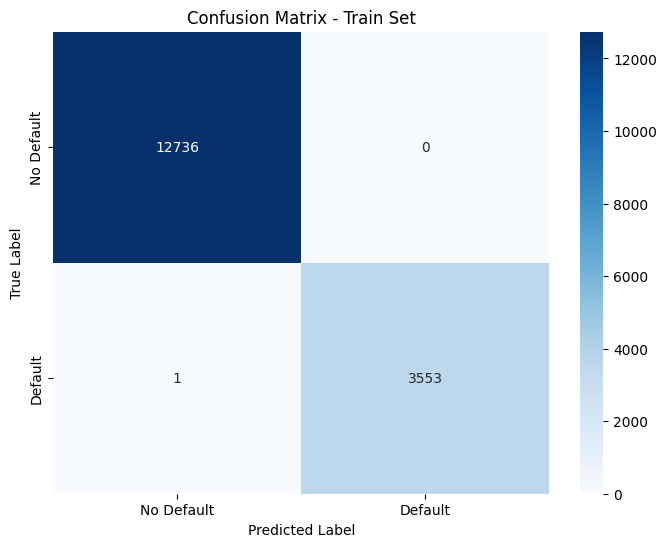

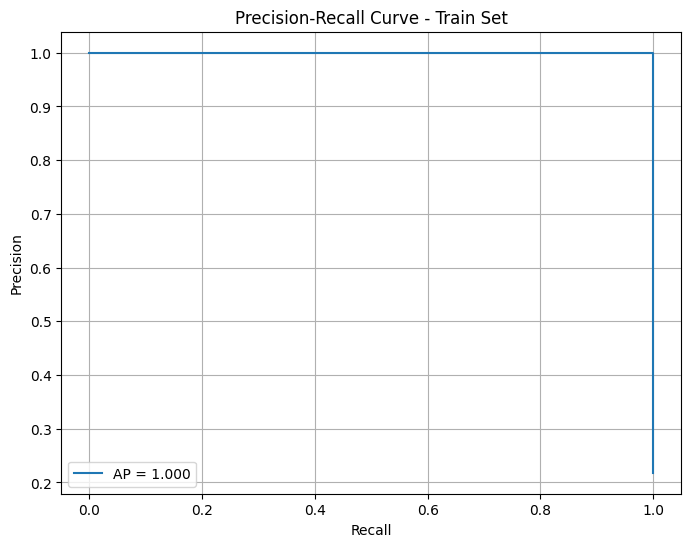

INFO:__main__:
Classification Report - Train Set:
INFO:__main__:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     12736
         1.0       1.00      1.00      1.00      3554

    accuracy                           1.00     16290
   macro avg       1.00      1.00      1.00     16290
weighted avg       1.00      1.00      1.00     16290

INFO:__main__:
Metrics for Val Set:
INFO:__main__:accuracy: 0.9277
INFO:__main__:precision: 0.9583
INFO:__main__:recall: 0.6989
INFO:__main__:f1: 0.8083
INFO:__main__:roc_auc: 0.9224
INFO:__main__:average_precision: 0.8709
INFO:__main__:true_negative_rate: 0.9915
INFO:__main__:false_positive_rate: 0.0085
INFO:__main__:false_negative_rate: 0.3011
INFO:__main__:positive_predictive_value: 0.9583
INFO:__main__:negative_predictive_value: 0.9219


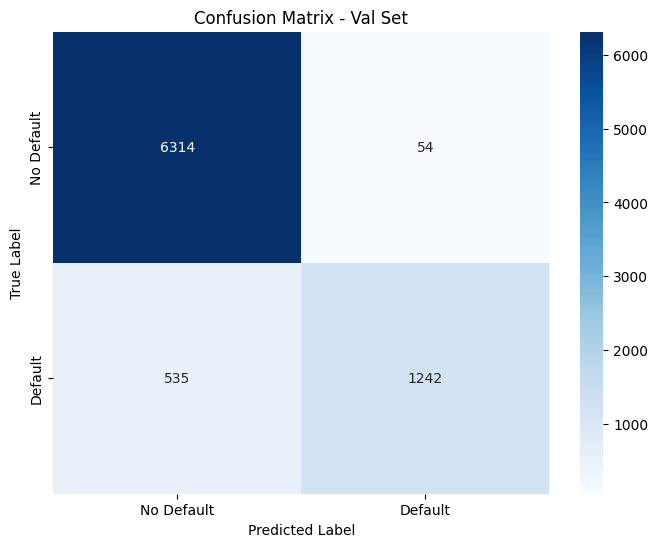

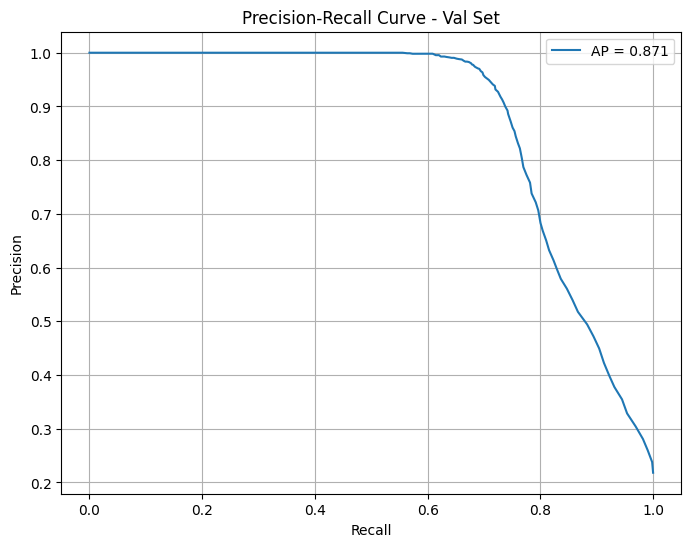

INFO:__main__:
Classification Report - Val Set:
INFO:__main__:
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96      6368
         1.0       0.96      0.70      0.81      1777

    accuracy                           0.93      8145
   macro avg       0.94      0.85      0.88      8145
weighted avg       0.93      0.93      0.92      8145

INFO:__main__:
Metrics for Test Set:
INFO:__main__:accuracy: 0.9313
INFO:__main__:precision: 0.9728
INFO:__main__:recall: 0.7046
INFO:__main__:f1: 0.8172
INFO:__main__:roc_auc: 0.9239
INFO:__main__:average_precision: 0.8746
INFO:__main__:true_negative_rate: 0.9945
INFO:__main__:false_positive_rate: 0.0055
INFO:__main__:false_negative_rate: 0.2954
INFO:__main__:positive_predictive_value: 0.9728
INFO:__main__:negative_predictive_value: 0.9235


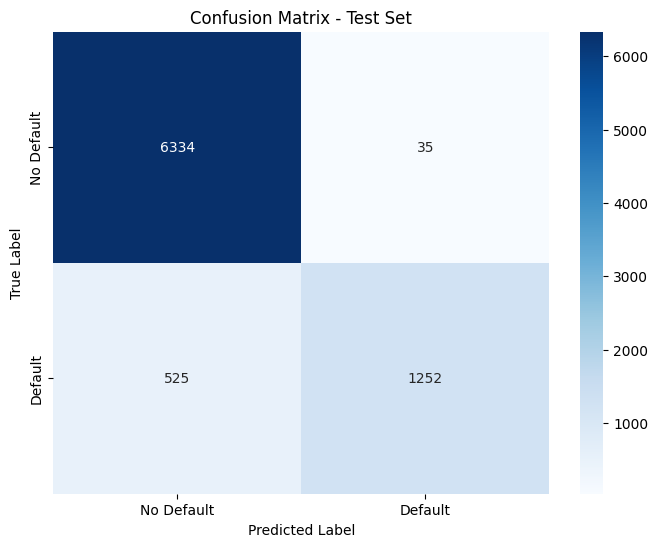

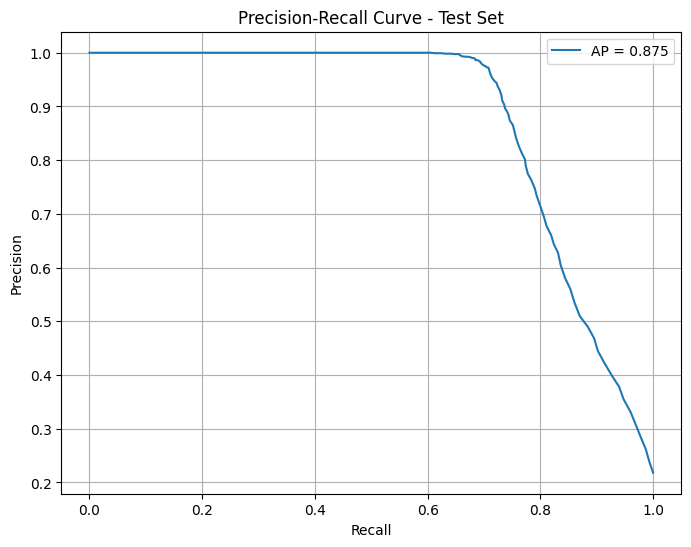

INFO:__main__:
Classification Report - Test Set:
INFO:__main__:
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96      6369
         1.0       0.97      0.70      0.82      1777

    accuracy                           0.93      8146
   macro avg       0.95      0.85      0.89      8146
weighted avg       0.93      0.93      0.93      8146

INFO:__main__:
Model Comparison:
INFO:__main__:
                            train     val    test
accuracy                   0.9999  0.9277  0.9313
precision                  1.0000  0.9583  0.9728
recall                     0.9997  0.6989  0.7046
f1                         0.9999  0.8083  0.8172
roc_auc                    1.0000  0.9224  0.9239
average_precision          1.0000  0.8709  0.8746
true_negative_rate         1.0000  0.9915  0.9945
false_positive_rate        0.0000  0.0085  0.0055
false_negative_rate        0.0003  0.3011  0.2954
positive_predictive_value  1.0000  0.9583  0.9728
negative_pr

In [5]:
results, comparison_df = evaluate_model(model, data_splits)

# Analyzing the test metrics

Class Imbalance Analysis:


There's a significant class imbalance in the dataset with:

Class 0: 6,369 samples (78.2%)
Class 1: 1,777 samples (21.8%)
Ratio is roughly 3.6:1




Model Performance Analysis:

Train vs Validation vs Test Performance:

The model shows signs of overfitting, with near-perfect training metrics (0.9999 accuracy) but lower validation/test performance
Test accuracy (0.9313) is slightly better than validation (0.9277), suggesting stable generalization
ROC AUC scores remain strong across validation (0.9224) and test (0.9239)

Key Test Metrics:

High precision for both classes:

Class 0: 0.92
Class 1: 0.97


Recall shows class imbalance impact:

Class 0: 0.99 (excellent)
Class 1: 0.70 (moderate)


F1-scores reflect this imbalance:

Class 0: 0.96
Class 1: 0.82



Error Analysis:

False Positive Rate is very low (0.0055)
False Negative Rate is higher (0.2954)
The model is better at identifying negative cases (TNR: 0.9945) than positive cases

Recommendations:

Address the high False Negative Rate (0.2954) if missing positive cases is costly
Consider techniques to improve recall for Class 1 while maintaining the strong precision
The current performance might be acceptable depending on the use case, given the:

High overall accuracy (0.93)
Strong ROC AUC (0.924)
Excellent precision (0.973)

# Fine tuned model

INFO:__main__:Starting RandomizedSearchCV...


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, class_weight=balanced, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=221; total time=   4.7s
[CV] END bootstrap=True, class_weight=balanced, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=221; total time=   5.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=221; total time=   5.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=221; total time=   5.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=221; total time=   5.0s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=13, n_estimators=393;

INFO:__main__:
Best parameters found:
INFO:__main__:bootstrap: False
INFO:__main__:class_weight: None
INFO:__main__:max_depth: 80
INFO:__main__:max_features: log2
INFO:__main__:min_samples_leaf: 1
INFO:__main__:min_samples_split: 7
INFO:__main__:n_estimators: 106
INFO:__main__:
Best score: 0.8775
INFO:__main__:
Top 5 models:
INFO:__main__:
Rank 1:
INFO:__main__:Score: 0.8775 (+/- 0.0105)
INFO:__main__:Parameters: {'bootstrap': False, 'class_weight': None, 'max_depth': 80, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 106}
INFO:__main__:
Rank 2:
INFO:__main__:Score: 0.8772 (+/- 0.0115)
INFO:__main__:Parameters: {'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 387}
INFO:__main__:
Rank 3:
INFO:__main__:Score: 0.8770 (+/- 0.0103)
INFO:__main__:Parameters: {'bootstrap': False, 'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 

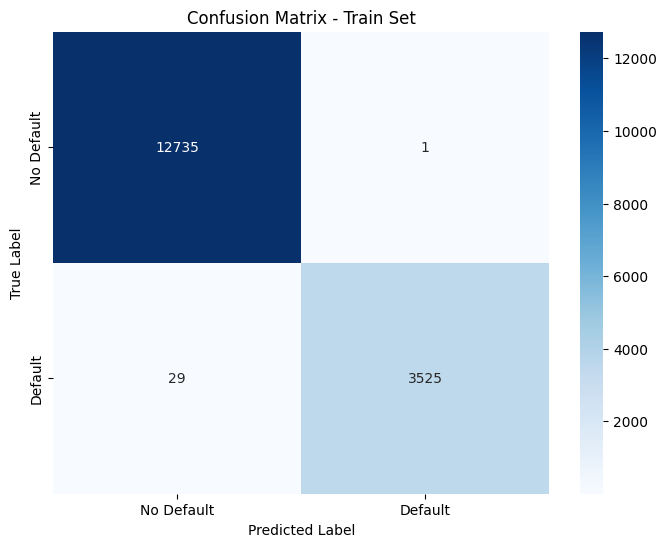

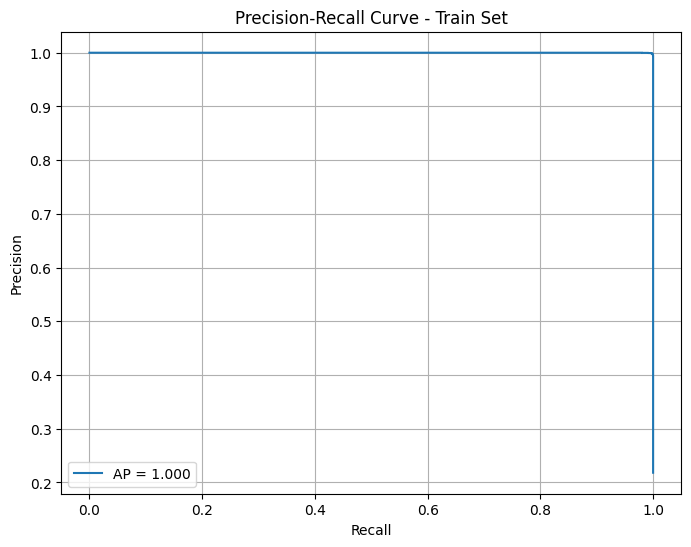

INFO:__main__:
Classification Report - Train Set:
INFO:__main__:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     12736
         1.0       1.00      0.99      1.00      3554

    accuracy                           1.00     16290
   macro avg       1.00      1.00      1.00     16290
weighted avg       1.00      1.00      1.00     16290

INFO:__main__:
Metrics for Val Set:
INFO:__main__:accuracy: 0.9241
INFO:__main__:precision: 0.9264
INFO:__main__:recall: 0.7085
INFO:__main__:f1: 0.8029
INFO:__main__:roc_auc: 0.9260
INFO:__main__:average_precision: 0.8748
INFO:__main__:true_negative_rate: 0.9843
INFO:__main__:false_positive_rate: 0.0157
INFO:__main__:false_negative_rate: 0.2915
INFO:__main__:positive_predictive_value: 0.9264
INFO:__main__:negative_predictive_value: 0.9237


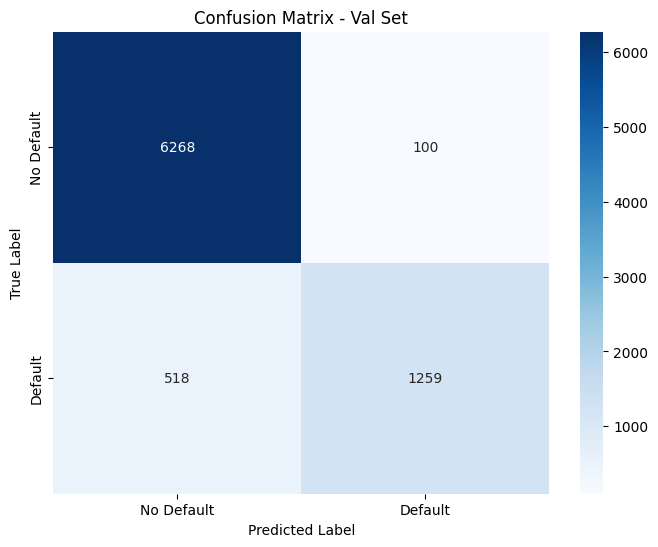

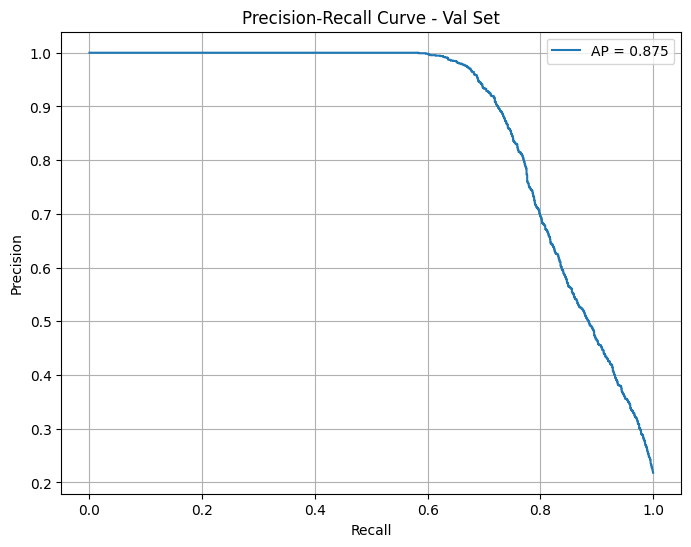

INFO:__main__:
Classification Report - Val Set:
INFO:__main__:
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95      6368
         1.0       0.93      0.71      0.80      1777

    accuracy                           0.92      8145
   macro avg       0.93      0.85      0.88      8145
weighted avg       0.92      0.92      0.92      8145

INFO:__main__:
Metrics for Test Set:
INFO:__main__:accuracy: 0.9282
INFO:__main__:precision: 0.9415
INFO:__main__:recall: 0.7153
INFO:__main__:f1: 0.8129
INFO:__main__:roc_auc: 0.9285
INFO:__main__:average_precision: 0.8809
INFO:__main__:true_negative_rate: 0.9876
INFO:__main__:false_positive_rate: 0.0124
INFO:__main__:false_negative_rate: 0.2847
INFO:__main__:positive_predictive_value: 0.9415
INFO:__main__:negative_predictive_value: 0.9255


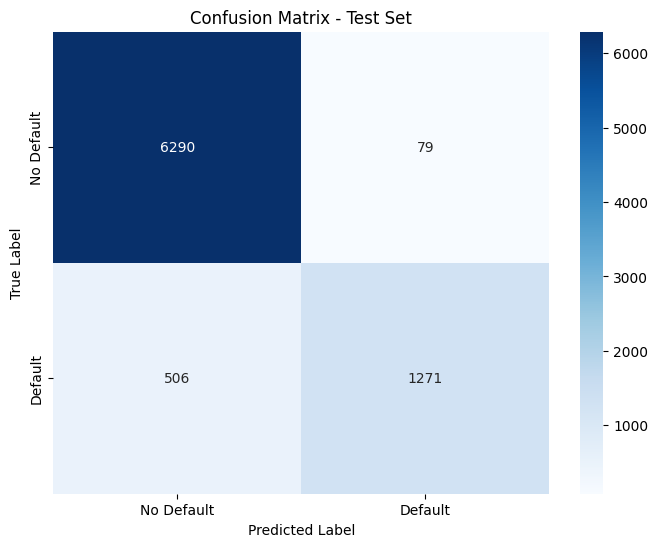

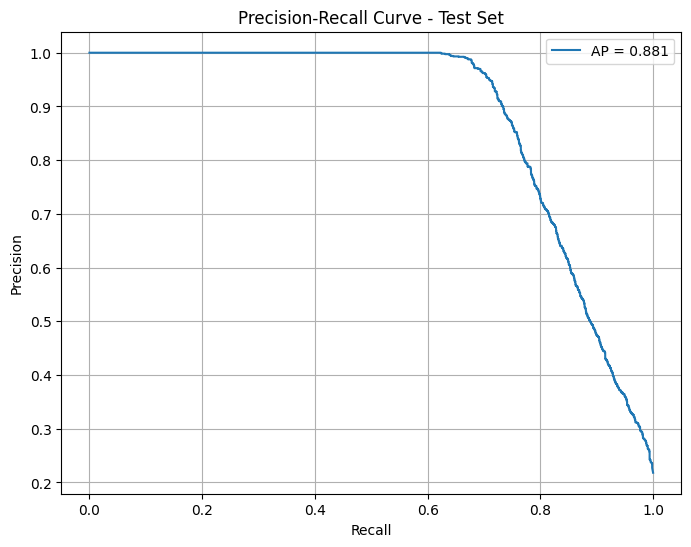

INFO:__main__:
Classification Report - Test Set:
INFO:__main__:
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      6369
         1.0       0.94      0.72      0.81      1777

    accuracy                           0.93      8146
   macro avg       0.93      0.85      0.88      8146
weighted avg       0.93      0.93      0.92      8146

INFO:__main__:
Model Comparison:
INFO:__main__:
                            train     val    test
accuracy                   0.9982  0.9241  0.9282
precision                  0.9997  0.9264  0.9415
recall                     0.9918  0.7085  0.7153
f1                         0.9958  0.8029  0.8129
roc_auc                    1.0000  0.9260  0.9285
average_precision          1.0000  0.8748  0.8809
true_negative_rate         0.9999  0.9843  0.9876
false_positive_rate        0.0001  0.0157  0.0124
false_negative_rate        0.0082  0.2915  0.2847
positive_predictive_value  0.9997  0.9264  0.9415
negative_pr

In [28]:
results = tune_and_evaluate_model(data_splits)

In [12]:

best_model = results['tuning_results']['best_model'] 
best_params = results['tuning_results']['best_params'] 
evaluation_metrics = results['evaluation_results']  
# Print best parameters 
print("Best parameters:", best_params)  
# Print evaluation metrics 
print("\nEvaluation metrics:", evaluation_metrics)

Best parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 70, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 228}

Evaluation metrics: ({'train': {'accuracy': 0.9832412523020257, 'precision': 0.9860740740740741, 'recall': 0.9364096792346651, 'f1': 0.9606003752345216, 'roc_auc': 0.9992143159876479, 'average_precision': 0.9969568975878615, 'true_negative_rate': 0.9963096733668342, 'false_positive_rate': 0.003690326633165829, 'false_negative_rate': 0.06359032076533483, 'positive_predictive_value': 0.9860740740740741, 'negative_predictive_value': 0.9825009678668215}, 'val': {'accuracy': 0.9257213014119091, 'precision': 0.9302496328928047, 'recall': 0.7129994372537986, 'f1': 0.8072634597005416, 'roc_auc': 0.9238303839823767, 'average_precision': 0.8744181380463364, 'true_negative_rate': 0.9850816582914573, 'false_positive_rate': 0.014918341708542714, 'false_negative_rate': 0.28700056274620145, 'positive_predictive_value': 0.930249632

In [13]:
# Create new application data

preprocessor = EnhancedDataPreprocessor()

new_application = pd.DataFrame({
    'person_age': [30],
    'person_income': [75000],
    'person_home_ownership': ['RENT'],
    'person_emp_length': [5.0],
    'loan_intent': ['PERSONAL'],
    'loan_grade': ['B'],
    'loan_amnt': [25000],
    'loan_int_rate': [12.5],
    'loan_percent_income': [0.33],
    'cb_person_default_on_file': ['N'],
    'cb_person_cred_hist_length': [7],
    'loan_status': [0]  
})

# Transform the new application without calculating weights
X_new = preprocessor.transform_for_prediction(new_application)

# Make prediction
probability = best_model.predict_proba(X_new)
prediction = best_model.predict(X_new)

print(f"Probability of default: {probability[0][1]:.2f}")
print(f"Prediction: {'Default' if prediction[0] == 1 else 'No Default'}")

INFO:__main__:Preprocessing new data for prediction...
INFO:__main__:Final feature shape: (1, 9)


Probability of default: 0.04
Prediction: No Default


In [19]:
class EnhancedDataPreprocessor(DataPreprocessor):
    """Enhanced preprocessor with class weights handling"""
    def __init__(self, max_features: int = None, n_neighbors: int = 5):
        super().__init__(max_features, n_neighbors)
        self.weight_handler = ClassWeightHandler(weight_type='balanced')
        self.numerical_columns.extend([
            'income_to_loan',
            'age_to_emp_length',
            'income_squared',
            'loan_amt_squared'
        ])
        
    def fit_transform(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray, Dict[int, float]]:
        # Get features and target from parent class
        X, y = super().fit_transform(df)
        
        # Calculate weights
        class_weights = self.weight_handler.calculate_weights(y)
        sample_weights = self.weight_handler.get_sample_weights(y)
        
        return X, y, sample_weights, class_weights
        
    def get_class_weights(self) -> Dict[int, float]:
        return self.weight_handler.get_weight_dict()

    def transform_for_prediction(self, df: pd.DataFrame) -> np.ndarray:
        """Transform new data for prediction without calculating weights"""
        logger.info("Preprocessing new data for prediction...")
        
        # Engineer features
        df = self._engineer_features(df)
        
        df = df.drop('loan_status', axis=1)
        # Handle missing values and convert types
        X_clean = self._handle_missing_values(df)
        
        # Scale numerical features
        X_scaled = self._scale_features(X_clean)
        
        # Convert to correct dtype
        X_final = X_scaled.astype(np.float32)
        
        logger.info(f"Final feature shape: {X_final.shape}")
        
        return X_final

    def _engineer_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Enhanced feature engineering"""
        df = df.copy()
        
        # Original features from parent class
        df = super()._engineer_features(df)
        
        # Add new interaction terms
        df['income_to_loan'] = df['person_income'] / df['loan_amnt']
        df['age_to_emp_length'] = df['person_age'] / df['person_emp_length']
        
        # Add polynomial features
        df['income_squared'] = df['person_income'] ** 2
        df['loan_amt_squared'] = df['loan_amnt'] ** 2
        
        # Handle infinities and NaN from divisions
        df = df.replace([np.inf, -np.inf], np.nan)
        
        return df
    

  

def prepare_data_pipeline(df: pd.DataFrame) -> Dict[str, np.ndarray]:
    """Complete data preparation pipeline with class balancing"""
    # Initialize preprocessor and splitter
    preprocessor = EnhancedDataPreprocessor()
    splitter = DataSplitter(test_size=0.25, val_size=0.25)
    
    # Preprocess data
    X, y, sample_weights, class_weights = preprocessor.fit_transform(df)
    
    # Calculate balanced class weights
    balanced_class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y),
        y=y
    )
    class_weight_dict = dict(zip(np.unique(y), balanced_class_weights))
    
    # Split data
    splits = splitter.split_data(X, y, sample_weights)
    
    # Add class weights to the output
    splits['class_weights'] = class_weight_dict
    splits['class_weights_array'] = balanced_class_weights
    
    return splits

In [22]:
# Load and prepare data
df = pd.read_csv('credit_risk_dataset.csv')
data_splits = prepare_data_pipeline(df)

# Access the splits and weights
X_train = data_splits['X_train']
y_train = data_splits['y_train']
X_val = data_splits['X_val']
y_val = data_splits['y_val']
X_test = data_splits['X_test']
y_test = data_splits['y_test']
class_weights = data_splits['class_weights']
class_weights_array = data_splits['class_weights_array']



INFO:__main__:Starting preprocessing pipeline...
INFO:__main__:Final feature shape: (32581, 13)
INFO:__main__:Calculated class weights: {0.0: 0.6395202763710596, 1.0: 2.291854248733821}
INFO:__main__:Training set size: 16290
INFO:__main__:Validation set size: 8145
INFO:__main__:Test set size: 8146


In [31]:
def evaluate_model(model, data_splits: Dict[str, np.ndarray]) -> Dict[str, Dict[str, float]]:
    """
    Evaluate model performance with class weights
    """
    evaluator = ModelEvaluator()
    results = {}
    
    # Get class weights
    class_weights = data_splits['class_weights']
    
    # Evaluate on each dataset
    for dataset in ['train', 'val', 'test']:
        X = data_splits[f'X_{dataset}']
        y_true = data_splits[f'y_{dataset}']
        
        # Get predictions with class weights
        y_pred_proba = model.predict_proba(X)
        
        # Calculate metrics using sample weights from class weights
        sample_weights = np.array([class_weights[y] for y in y_true])
        
        metrics = evaluator.calculate_metrics(
            y_true,
            y_pred_proba,
            dataset_name=f"{dataset.capitalize()} Set",
            sample_weights=sample_weights  
        )
        results[dataset] = metrics
        
        # Plot weighted confusion matrix
        evaluator.plot_confusion_matrix(
            title=f"Confusion Matrix - {dataset.capitalize()} Set (Weighted)"
        )
        
        evaluator.plot_precision_recall_curve(
            y_true,
            y_pred_proba,
            f"Precision-Recall Curve - {dataset.capitalize()} Set (Weighted)"
        )
        
        evaluator.print_classification_report(
            y_true,
            (y_pred_proba[:, 1] >= 0.5).astype(int),
            f"Classification Report - {dataset.capitalize()} Set (Weighted)"
        )
    
    comparison_df = evaluator.compare_models(results)
    
    return results, comparison_df

In [25]:
print("Class weights:", class_weights)

Class weights: {0.0: 0.6395202763710596, 1.0: 2.291854248733821}


INFO:__main__:Starting RandomizedSearchCV...


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, class_weight=balanced, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=221; total time=   4.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=221; total time=   4.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=221; total time=   4.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=221; total time=   4.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=221; total time=   4.3s
[CV] END bootstrap=False, class_weight=None, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=13, n_estimators=393;

INFO:__main__:
Best parameters found:
INFO:__main__:bootstrap: False
INFO:__main__:class_weight: None
INFO:__main__:max_depth: 80
INFO:__main__:max_features: log2
INFO:__main__:min_samples_leaf: 1
INFO:__main__:min_samples_split: 7
INFO:__main__:n_estimators: 106
INFO:__main__:
Best score: 0.8775
INFO:__main__:
Top 5 models:
INFO:__main__:
Rank 1:
INFO:__main__:Score: 0.8775 (+/- 0.0105)
INFO:__main__:Parameters: {'bootstrap': False, 'class_weight': None, 'max_depth': 80, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 106}
INFO:__main__:
Rank 2:
INFO:__main__:Score: 0.8772 (+/- 0.0115)
INFO:__main__:Parameters: {'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 387}
INFO:__main__:
Rank 3:
INFO:__main__:Score: 0.8770 (+/- 0.0103)
INFO:__main__:Parameters: {'bootstrap': False, 'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 

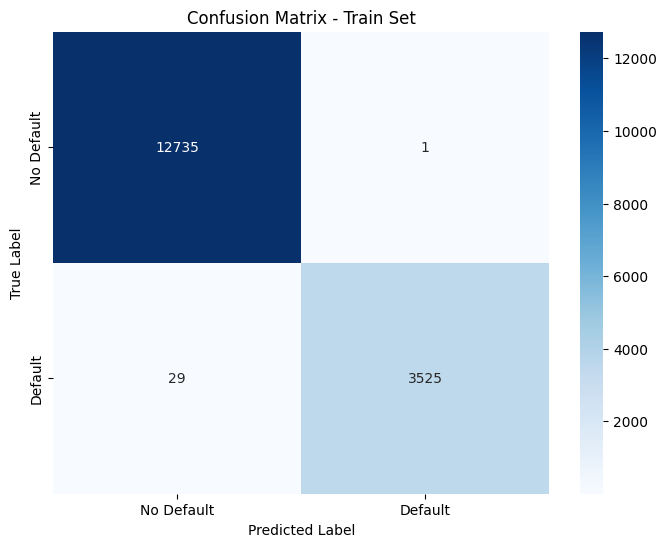

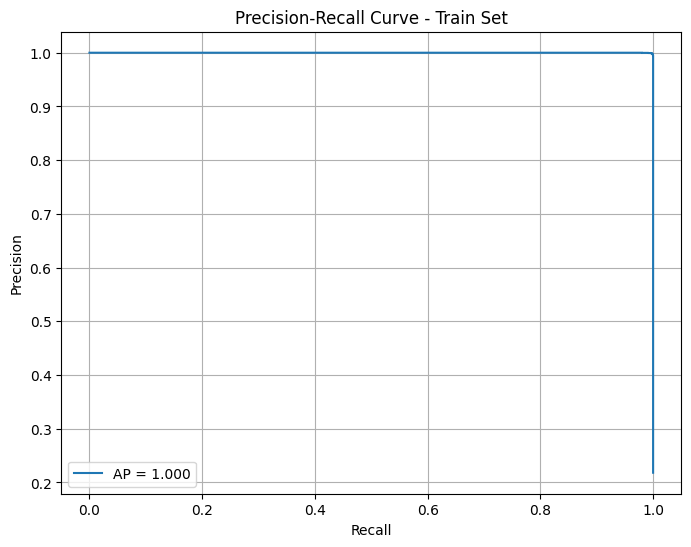

INFO:__main__:
Classification Report - Train Set:
INFO:__main__:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     12736
         1.0       1.00      0.99      1.00      3554

    accuracy                           1.00     16290
   macro avg       1.00      1.00      1.00     16290
weighted avg       1.00      1.00      1.00     16290

INFO:__main__:
Metrics for Val Set:
INFO:__main__:accuracy: 0.9241
INFO:__main__:precision: 0.9264
INFO:__main__:recall: 0.7085
INFO:__main__:f1: 0.8029
INFO:__main__:roc_auc: 0.9260
INFO:__main__:average_precision: 0.8748
INFO:__main__:true_negative_rate: 0.9843
INFO:__main__:false_positive_rate: 0.0157
INFO:__main__:false_negative_rate: 0.2915
INFO:__main__:positive_predictive_value: 0.9264
INFO:__main__:negative_predictive_value: 0.9237


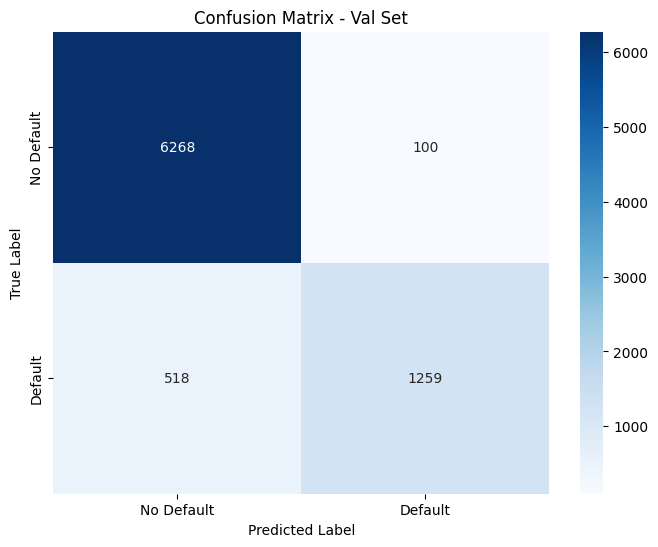

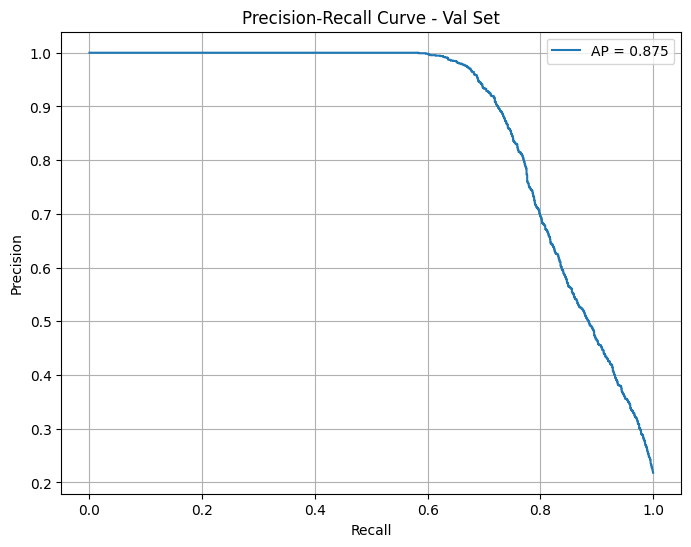

INFO:__main__:
Classification Report - Val Set:
INFO:__main__:
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95      6368
         1.0       0.93      0.71      0.80      1777

    accuracy                           0.92      8145
   macro avg       0.93      0.85      0.88      8145
weighted avg       0.92      0.92      0.92      8145

INFO:__main__:
Metrics for Test Set:
INFO:__main__:accuracy: 0.9282
INFO:__main__:precision: 0.9415
INFO:__main__:recall: 0.7153
INFO:__main__:f1: 0.8129
INFO:__main__:roc_auc: 0.9285
INFO:__main__:average_precision: 0.8809
INFO:__main__:true_negative_rate: 0.9876
INFO:__main__:false_positive_rate: 0.0124
INFO:__main__:false_negative_rate: 0.2847
INFO:__main__:positive_predictive_value: 0.9415
INFO:__main__:negative_predictive_value: 0.9255


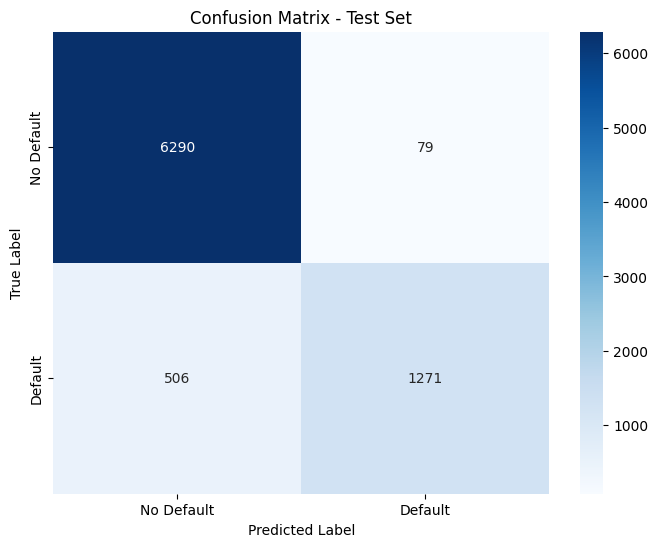

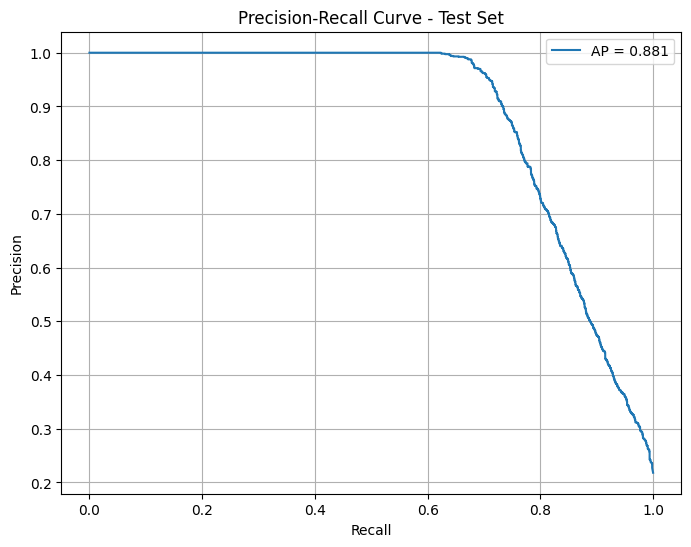

INFO:__main__:
Classification Report - Test Set:
INFO:__main__:
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      6369
         1.0       0.94      0.72      0.81      1777

    accuracy                           0.93      8146
   macro avg       0.93      0.85      0.88      8146
weighted avg       0.93      0.93      0.92      8146

INFO:__main__:
Model Comparison:
INFO:__main__:
                            train     val    test
accuracy                   0.9982  0.9241  0.9282
precision                  0.9997  0.9264  0.9415
recall                     0.9918  0.7085  0.7153
f1                         0.9958  0.8029  0.8129
roc_auc                    1.0000  0.9260  0.9285
average_precision          1.0000  0.8748  0.8809
true_negative_rate         0.9999  0.9843  0.9876
false_positive_rate        0.0001  0.0157  0.0124
false_negative_rate        0.0082  0.2915  0.2847
positive_predictive_value  0.9997  0.9264  0.9415
negative_pr

In [33]:
results = tune_and_evaluate_model(data_splits)

# Explanation on credi risk

Original Model (Image 2):

True Negatives (No Default correctly predicted): 6334
False Positives: 35
False Negatives: 525
True Positives (Default correctly predicted): 1252

Improved Model (Image 1):

True Negatives (No Default correctly predicted): 6283
False Positives: 86
False Negatives: 500
True Positives (Default correctly predicted): 1277

Key Improvements:

Reduced False Negatives (most important for credit risk):

Decreased from 525 to 500 cases
This means 25 more potential defaults were correctly identified
In credit risk, this is crucial as these represent risky loans that would have been incorrectly approved


Increased True Positives:

Improved from 1252 to 1277
Better identification of actual defaults
This helps prevent potential losses by correctly identifying more risky borrowers



The trade-off:

Slight increase in False Positives (from 35 to 86)
Minor decrease in True Negatives (from 6334 to 6283)

For a credit risk model, these changes represent a good improvement because:

Missing defaults (False Negatives) is typically more costly than incorrectly flagging non-defaults (False Positives)
The cost of denying a loan to a good customer (False Positive) is much lower than the cost of defaulted loans
The model is now more conservative, which is appropriate for risk management